<a href="https://colab.research.google.com/github/slnkahveci/UNetTest/blob/main/UNetFloodMapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# model

In [2]:
! pip install albumentations

from google.colab import drive
drive.mount('/content/drive')

# uses padded convolutions (unlike the original paper, which uses valid convolutions)
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

# each layer in decoder has 2 3x3conv+ReLU followed by maxpool

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # same convolution: input size = output size
            nn.BatchNorm2d(out_channels), # bias=False because batchnorm already has bias
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module): # modules needed for forward pass

    # paper has 2 output channels, this implementation is for binary segmentation
    # features is a list of number of features in each layer of the decoder/encoder
    def __init__(self, in_channels=6, out_channels=1, features=[64, 128, 256, 512]):

        # initialize nn.Module
        super(UNet, self).__init__()

        # ModuleList instead of normal list to register list elements as submodules of the module UNet
        self.downs = nn.ModuleList() # downsampling, encoder
        self.ups = nn.ModuleList() # upsampling, decoder
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # maxpooling floors the division, this might cause problems when upsampling

        # encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, out_channels=feature))
            in_channels = feature # update in_channels for next layer

        # bottleneck
        self.bottleneck = DoubleConv(
            features[-1], # last element in features list
            features[-1]*2) # double the number of features at the end of the encoder

        # decoder
        # transpose convolution (they sometimes create artifacts) or bilinear followed by DoubleConv (can bypass artifacts)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d( # up-conv 2x2
                in_channels=feature*2, # x2 because skip connections
                out_channels=feature,
                kernel_size=2,
                stride=2))
            self.ups.append(DoubleConv(feature*2, feature)) # double conv3x3,ReLU

        # final layer 1x1conv
        self.final_conv = nn.Conv2d(in_channels=features[0], out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            # save output of each layer for skip connections before pooling
            # first element has the highest resolution and least features
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse list for correct order

        for idx in range(0, len(self.ups), 2): # iterate by 2 because there is two elements in each layer
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                # sizes might mismatch due to maxpooling/upconv (original paper uses cropping instead of resizing)
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1) # concatenate along the channel dimension
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 160, 160))
    model = UNet(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


# dataset

In [3]:
import os
import sys
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from osgeo import gdal
import traceback

gdal.UseExceptions()
"""
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB")) #np.array for albumentations, it was PIL image
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) # convert to grayscale
        mask[mask == 255.0] = 1.0 # sigmoid function will be applied to the final layer, so we need to scale the mask to 0-1

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask
 """

class SARDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".tif", ".png"))

        try:
            ds = gdal.Open(img_path)
            if ds is None:
                print("Failed to open the image")
                sys.exit(1)


            band1 = ds.GetRasterBand(1)
            band2 = ds.GetRasterBand(2)
            band3 = ds.GetRasterBand(3)
            band4 = ds.GetRasterBand(4)
            band5 = ds.GetRasterBand(5)
            band6 = ds.GetRasterBand(6)


            image = np.dstack((band1.ReadAsArray(), band2.ReadAsArray(), band3.ReadAsArray(), band4.ReadAsArray(), band5.ReadAsArray(), band6.ReadAsArray()))
            mask = np.array(Image.open(mask_path).convert("L"), dtype=np.int16)


            if self.transform is not None:
                augmentations = self.transform(image=image, mask=mask)
                image = augmentations["image"]
                mask = augmentations["mask"]

        except Exception as e:
            print("An error occurred:")
            traceback.print_exc()
            # don't exit, just raise the exception
            raise e


        return image, mask

if __name__ == "__main__":
    dataset = SARDataset("/content/drive/MyDrive/Track1test/train/images", "/content/drive/MyDrive/Track1test/train/labels")
    print(len(dataset))
    print(dataset[0][0].shape) # image
    print(dataset[0][1].shape) # mask
    print(dataset[0][1]) # mask
    print(dataset[0][0]) # image
    print(dataset[0][0].max())
    print(dataset[0][0].min())
    print(dataset[0][1].max())
    print(dataset[0][1].min())
    print(dataset[0][0].dtype)
    print(dataset[0][1].dtype)


16
(512, 512, 6)
(512, 512)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
[[[4920  328   22   22   40    0]
  [4943  263   22   22   40    0]
  [4943  263   22   22   40    0]
  ...
  [ 901   34   35   34   40    0]
  [ 633   25   35   34   40    0]
  [ 693    1   35   34   40    0]]

 [[5512  230   22   22   40    0]
  [5859  246   22   22   40    0]
  [4083  224   22   22   40    0]
  ...
  [ 803   55   35   34   40    0]
  [ 520   17   35   34   40    0]
  [1067    0   35   34   40    0]]

 [[5391  160   22   22   40    0]
  [5512  246   22   22   40    0]
  [3136  387   22   22   40    0]
  ...
  [ 842  144   35   34   40    0]
  [ 583   55   35   34   40    0]
  [1133   15   35   34   40    0]]

 ...

 [[2218  368   80   79   40    0]
  [1587  511   80   79   40    0]
  [1762  264   80   79   40    0]
  ...
  [  74   31   24   17   80   97]
  [  64   31   24   17   80   96]
  [  36   13   24   17   80   92]]

# utils

In [4]:
import torch
import torchvision

from torch.utils.data import DataLoader

def save_checkpoint(state, filename="/content/drive/MyDrive/my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = SARDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = SARDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    print("Checking accuracy...")
    with torch.no_grad(): # no need to calculate gradients, it is not training. Saves memory
        for x, y in loader:

            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float() # binarize the predictions, works for multi-class as well
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            ) ## this is for binary classification, for multi-class use IoU
            # IoU is intersection over union
            # Dice is 2 * intersection / total areas of both images
            # Dice is more sensitive to false positives than IoU, but it is binary only
            print(f"Preds white: {preds.sum()}")
            print(f"Preds black: {(preds == 0).sum()}")
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}") # so we can compare the accuracy of the model to false only classification
    model.train()

def save_predictions_as_imgs(loader, model, folder="/content/drive/MyDrive/Track1/saved_images", device="cuda"):
    model.eval()

    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )


        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Display the prediction
        ax[0].imshow(preds[0].squeeze().cpu().numpy(), cmap='gray')
        ax[0].set_title(f'Prediction {idx}')
        ax[0].axis('off')

        # Display the ground truth
        ax[1].imshow(y[0].squeeze().cpu().numpy(), cmap='gray')
        ax[1].set_title(f'Ground Truth {idx}')
        ax[1].axis('off')

        plt.show()

    model.train()

# train

Data augmentation is set.
Validation data augmentation is set.
Model is set.
Loss function is set.
Optimizer is set.
Data loaders are set.
Checking accuracy...
Preds white: 616.0
Preds black: 4193688
Preds white: 1383.0
Preds black: 4192921
Preds white: 744.0
Preds black: 4193560
Preds white: 816.0
Preds black: 4193488
Preds white: 940.0
Preds black: 4193364
Preds white: 1361.0
Preds black: 4192943
Preds white: 654.0
Preds black: 4193650
Preds white: 882.0
Preds black: 4193422
Preds white: 536.0
Preds black: 4193768
Preds white: 628.0
Preds black: 4193676
Preds white: 1269.0
Preds black: 4193035
Preds white: 1072.0
Preds black: 4193232
Preds white: 1183.0
Preds black: 4193121
Preds white: 909.0
Preds black: 4193395
Preds white: 950.0
Preds black: 4193354
Preds white: 489.0
Preds black: 4193815
Preds white: 506.0
Preds black: 4193798
Preds white: 272.0
Preds black: 4194032
Preds white: 703.0
Preds black: 4193601
Preds white: 931.0
Preds black: 4193373
Preds white: 431.0
Preds black: 157

100%|██████████| 82/82 [12:40<00:00,  9.28s/it, loss=0.325]


=> Saving checkpoint
Checking accuracy...
Preds white: 354798.0
Preds black: 3839506
Preds white: 169595.0
Preds black: 4024709
Preds white: 237205.0
Preds black: 3957099
Preds white: 414949.0
Preds black: 3779355
Preds white: 117886.0
Preds black: 4076418
Preds white: 76366.0
Preds black: 4117938
Preds white: 50013.0
Preds black: 4144291
Preds white: 324401.0
Preds black: 3869903
Preds white: 317282.0
Preds black: 3877022
Preds white: 469125.0
Preds black: 3725179
Preds white: 89719.0
Preds black: 4104585
Preds white: 338811.0
Preds black: 3855493
Preds white: 313415.0
Preds black: 3880889
Preds white: 289424.0
Preds black: 3904880
Preds white: 265210.0
Preds black: 3929094
Preds white: 53721.0
Preds black: 4140583
Preds white: 168934.0
Preds black: 4025370
Preds white: 135244.0
Preds black: 4059060
Preds white: 116508.0
Preds black: 4077796
Preds white: 284403.0
Preds black: 3909901
Preds white: 51913.0
Preds black: 1520951
Got 82992713/85458944 with acc 97.11
Dice score: 0.705946981

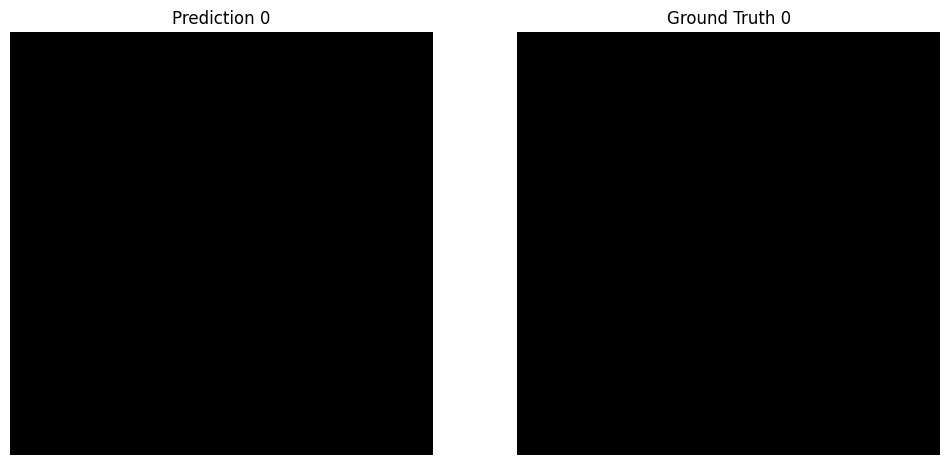

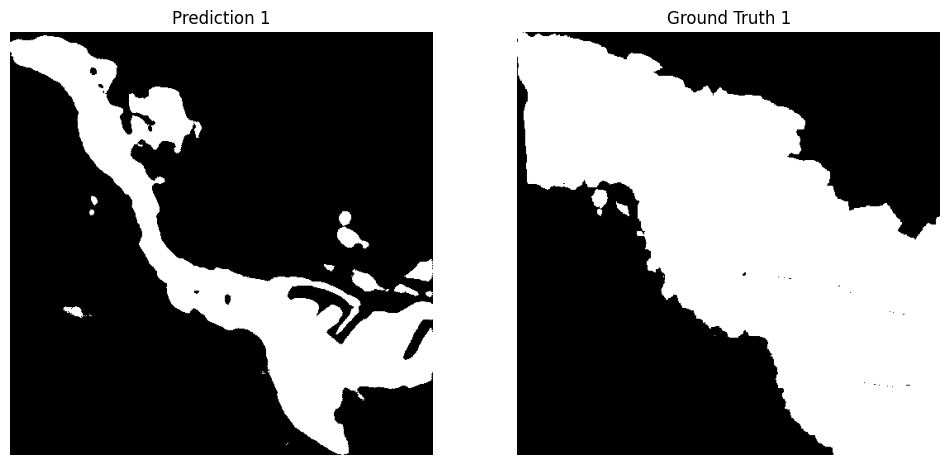

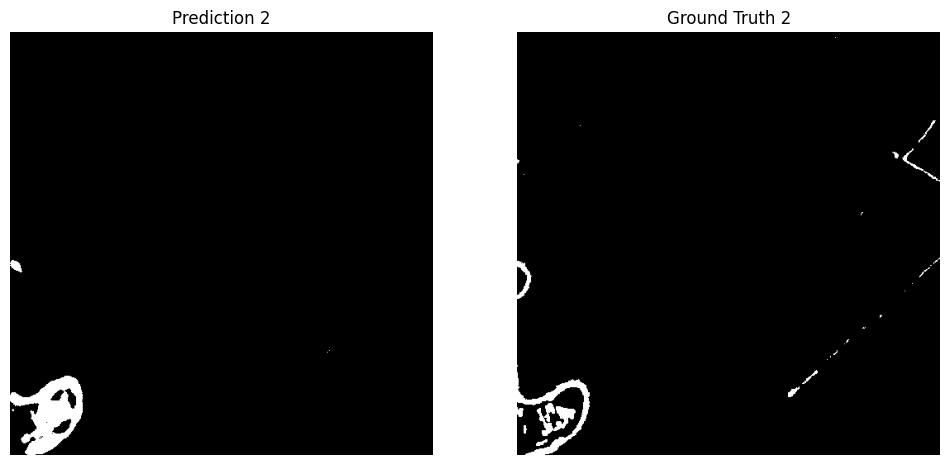

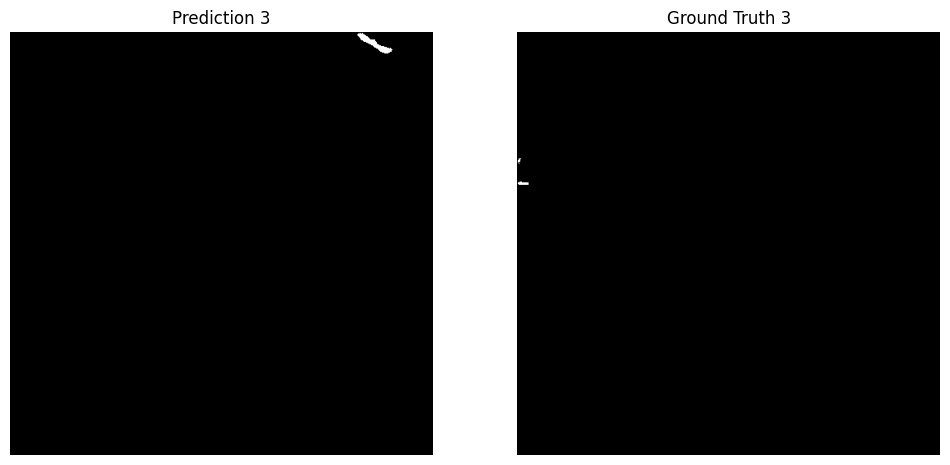

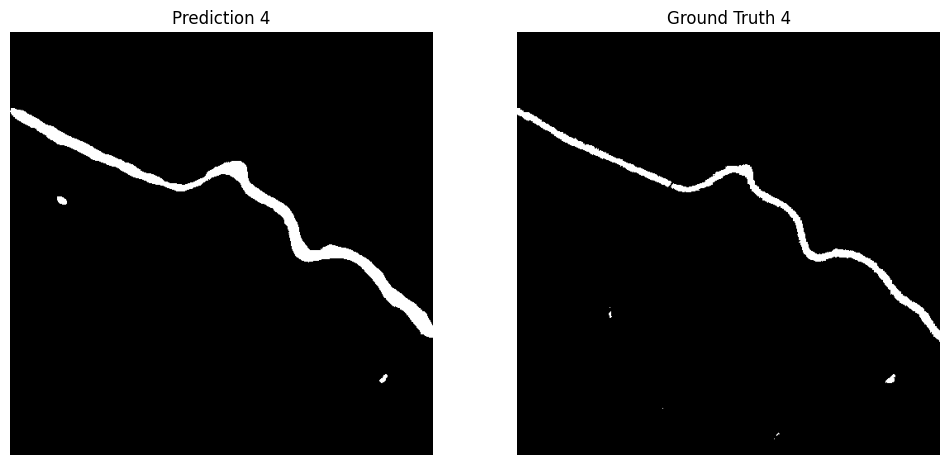

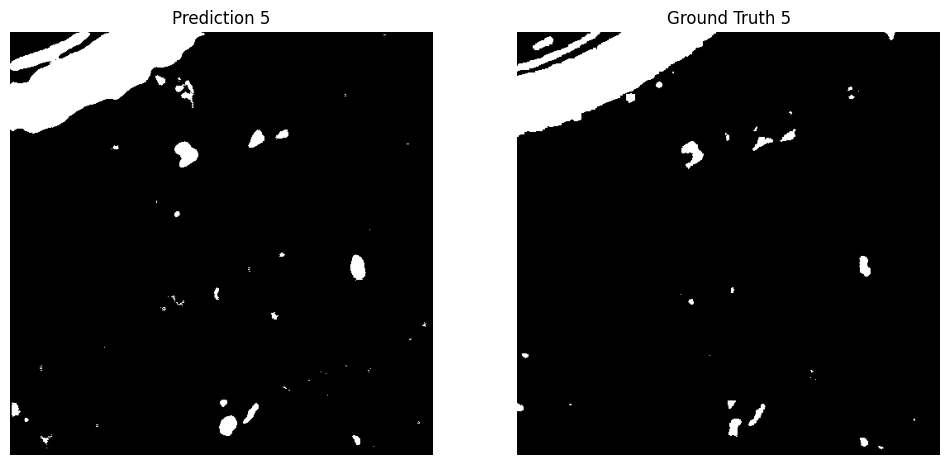

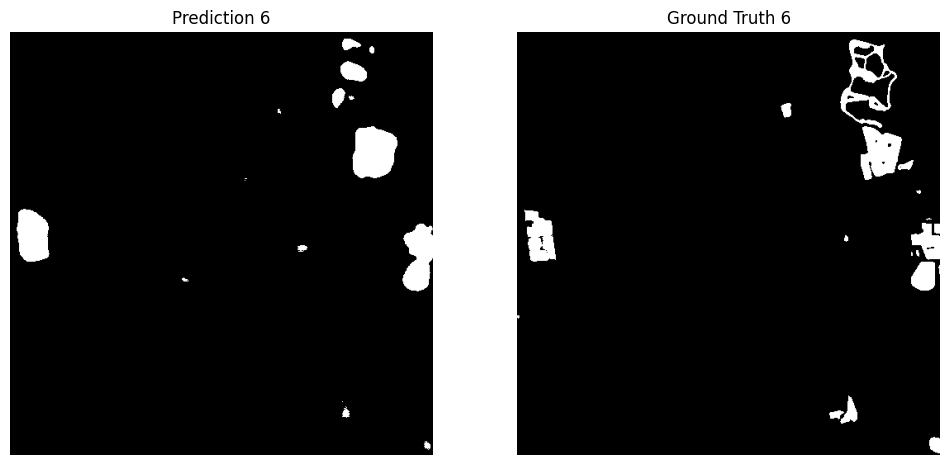

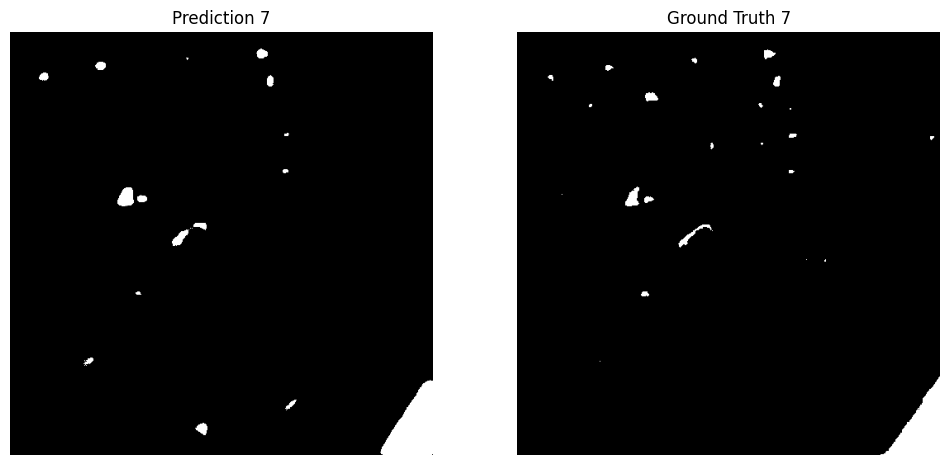

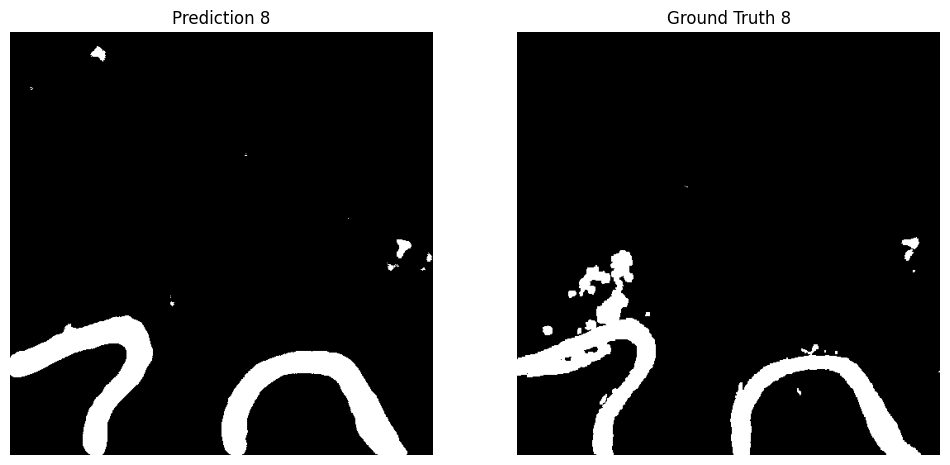

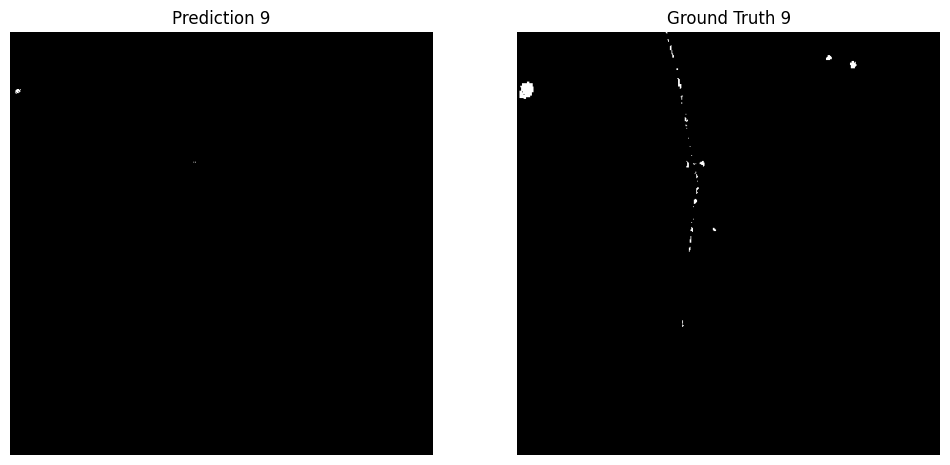

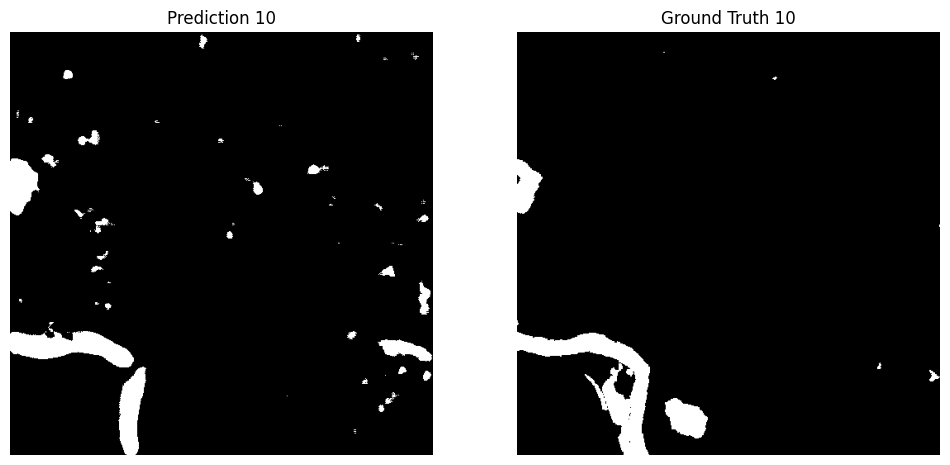

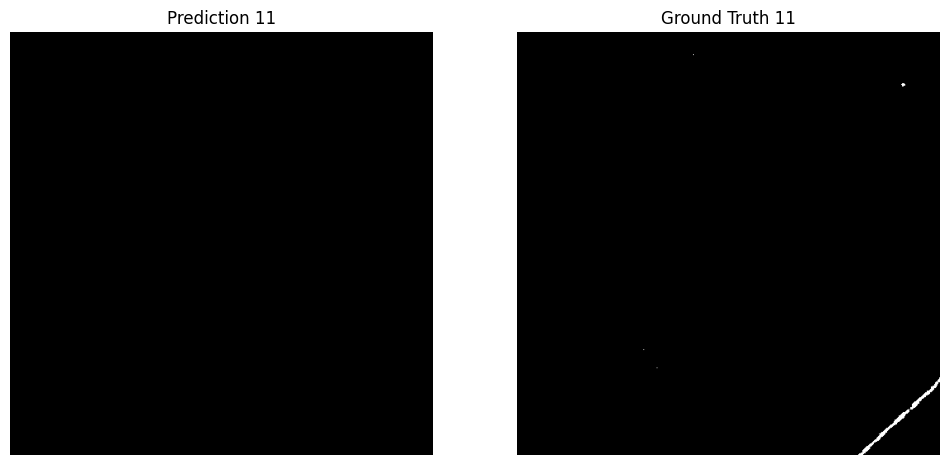

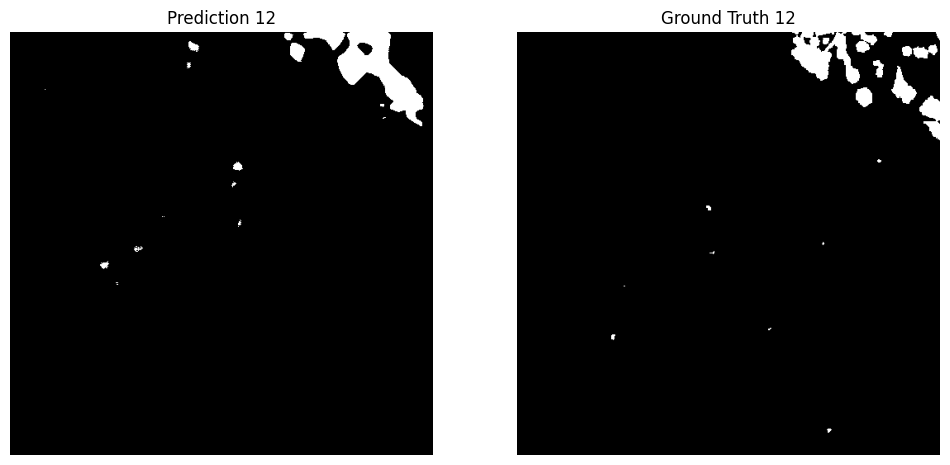

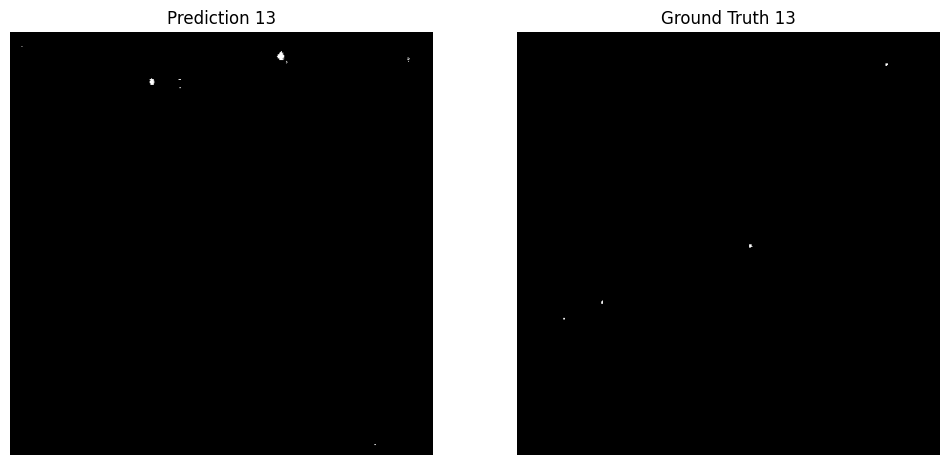

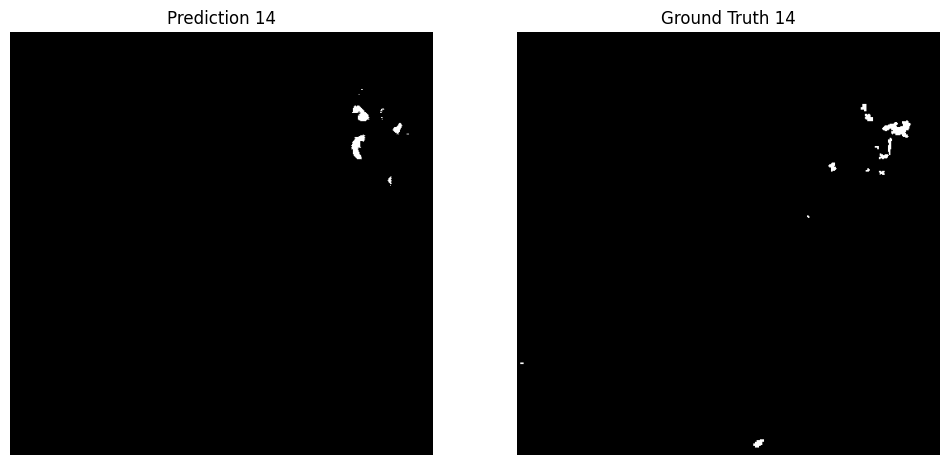

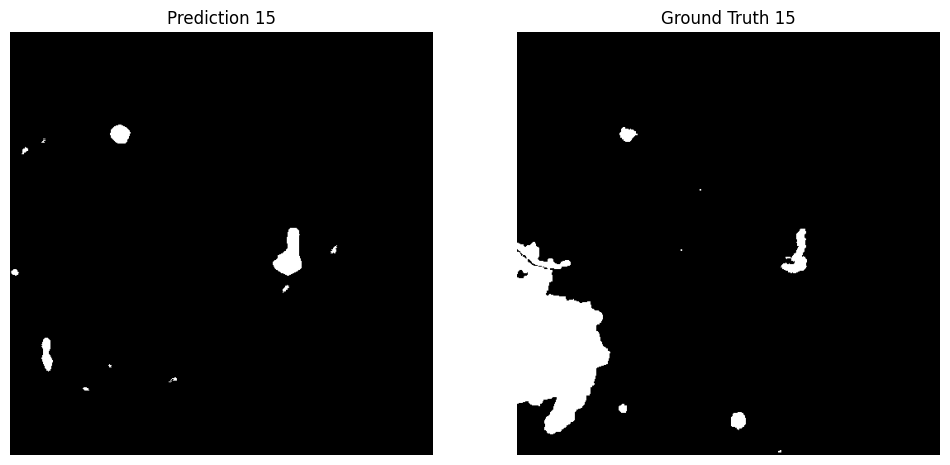

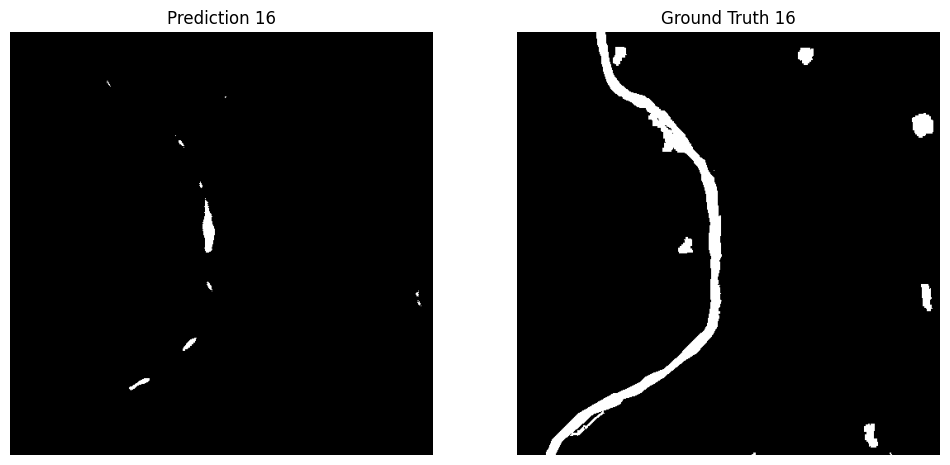

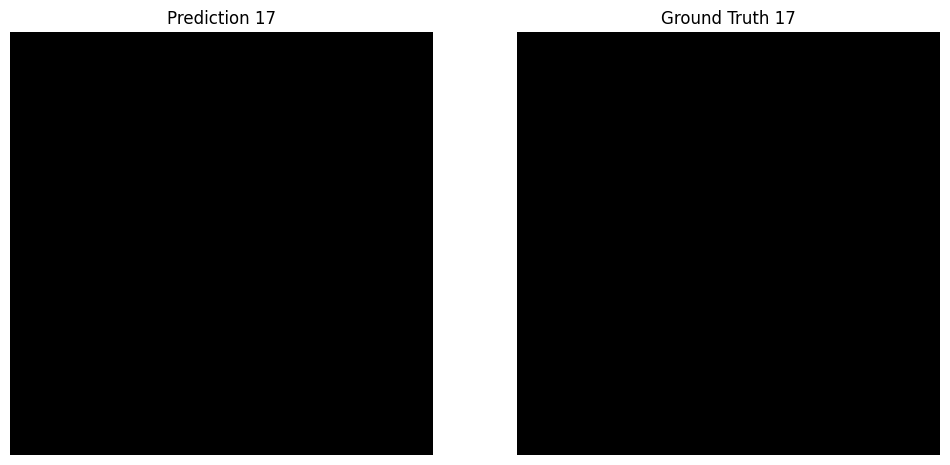

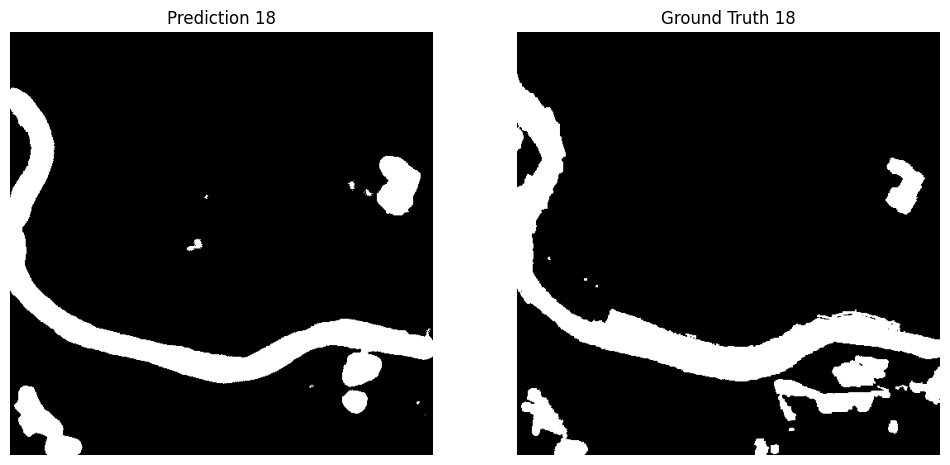

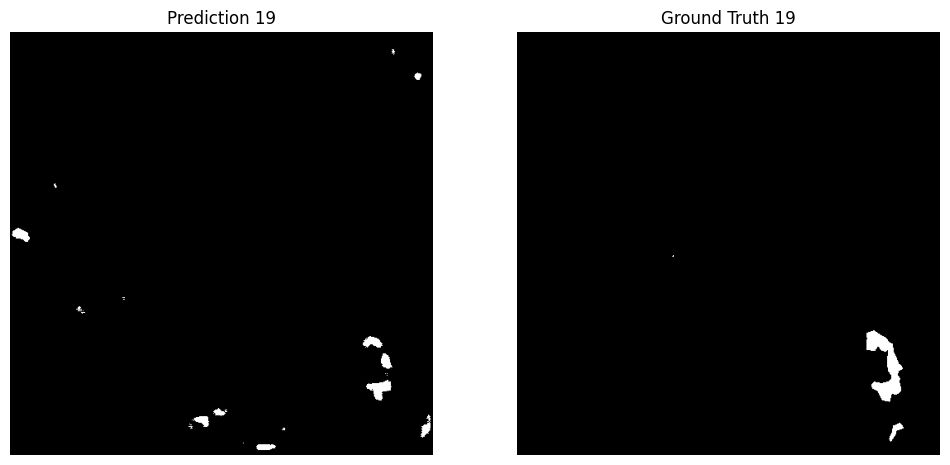

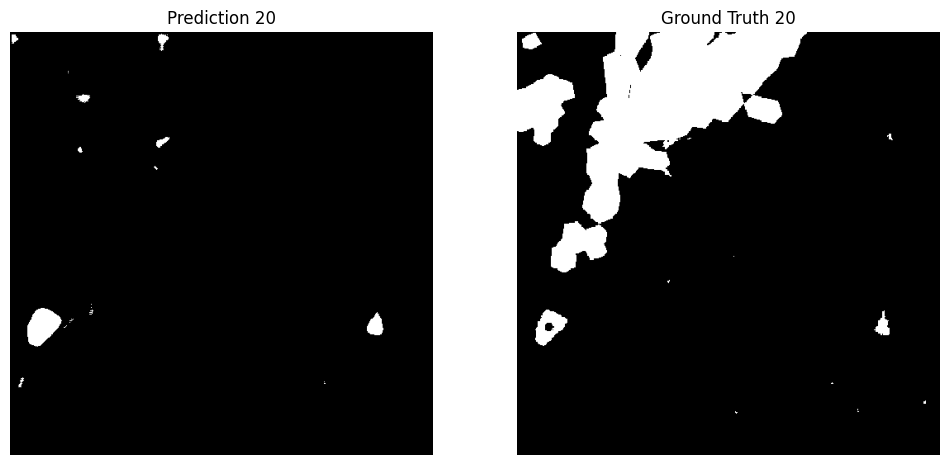

epoch 2


100%|██████████| 82/82 [02:55<00:00,  2.14s/it, loss=0.225]


=> Saving checkpoint
Checking accuracy...
Preds white: 280817.0
Preds black: 3913487
Preds white: 120682.0
Preds black: 4073622
Preds white: 162045.0
Preds black: 4032259
Preds white: 375925.0
Preds black: 3818379
Preds white: 67898.0
Preds black: 4126406
Preds white: 55754.0
Preds black: 4138550
Preds white: 33304.0
Preds black: 4161000
Preds white: 297791.0
Preds black: 3896513
Preds white: 271885.0
Preds black: 3922419
Preds white: 410407.0
Preds black: 3783897
Preds white: 38615.0
Preds black: 4155689
Preds white: 294843.0
Preds black: 3899461
Preds white: 265500.0
Preds black: 3928804
Preds white: 251231.0
Preds black: 3943073
Preds white: 244536.0
Preds black: 3949768
Preds white: 28020.0
Preds black: 4166284
Preds white: 145951.0
Preds black: 4048353
Preds white: 107294.0
Preds black: 4087010
Preds white: 78593.0
Preds black: 4115711
Preds white: 227587.0
Preds black: 3966717
Preds white: 47381.0
Preds black: 1525483
Got 83104684/85458944 with acc 97.25
Dice score: 0.68850946426

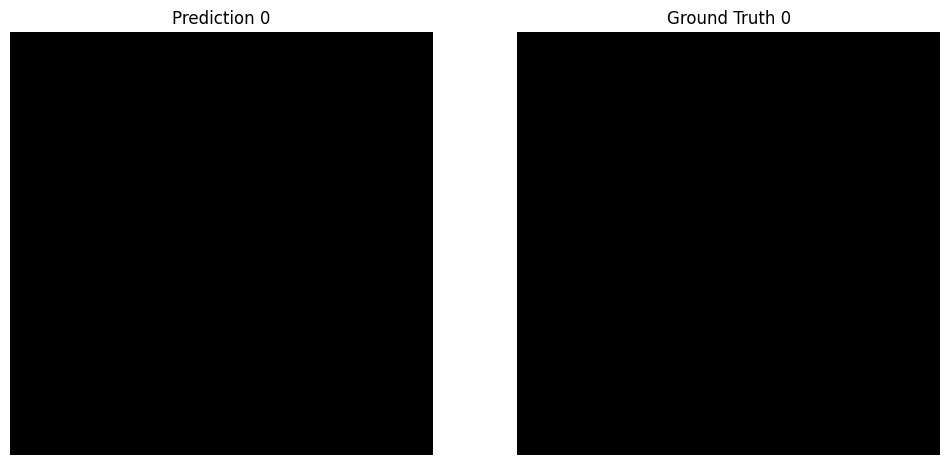

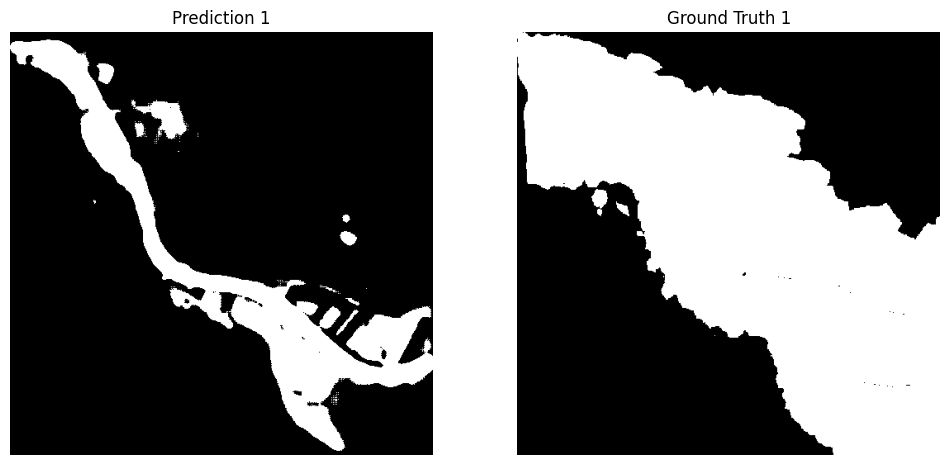

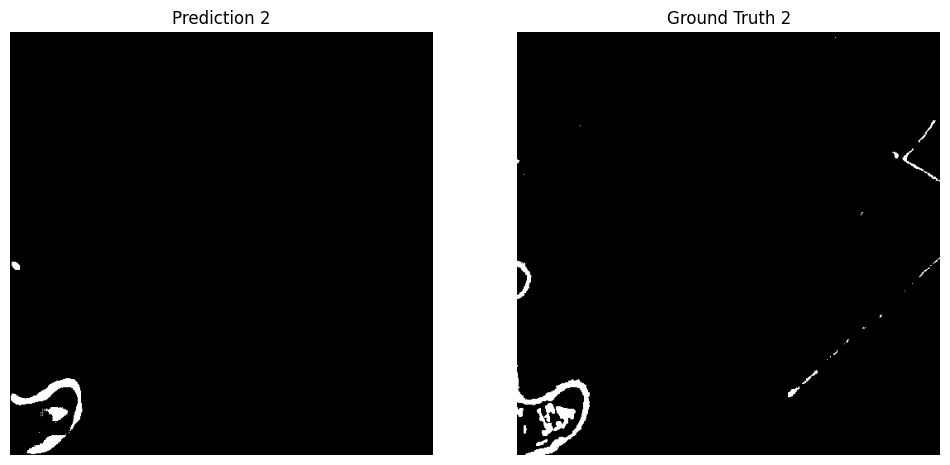

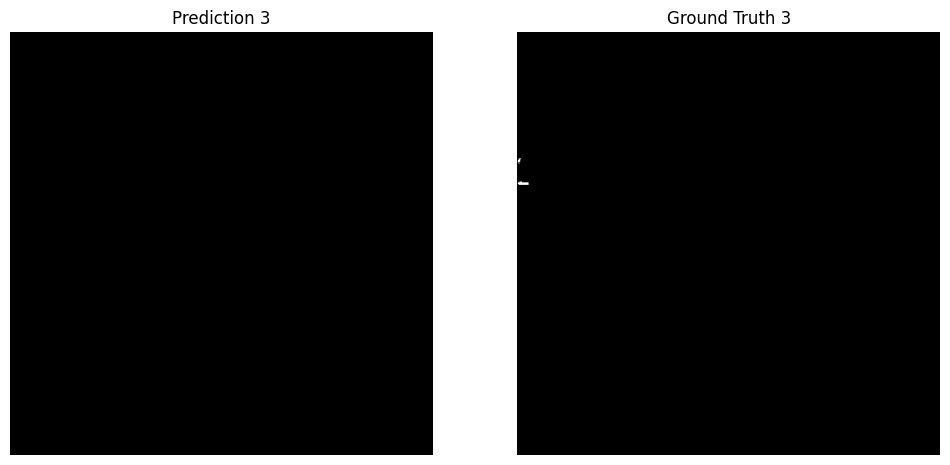

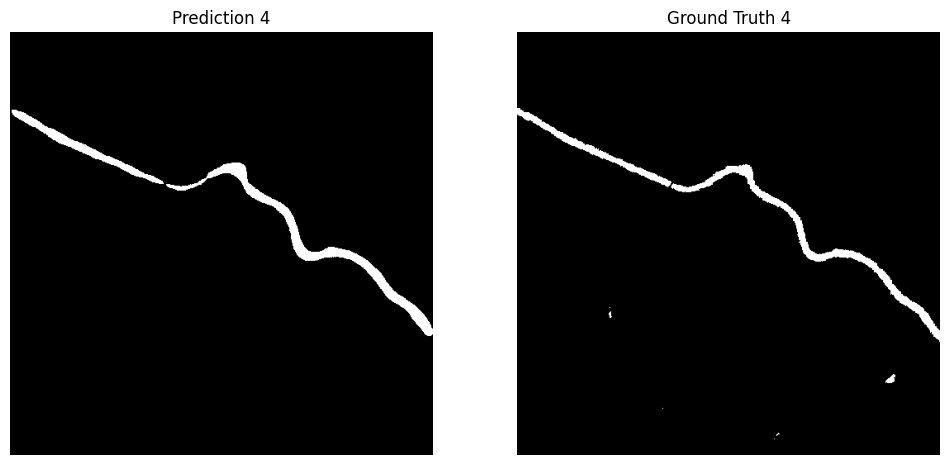

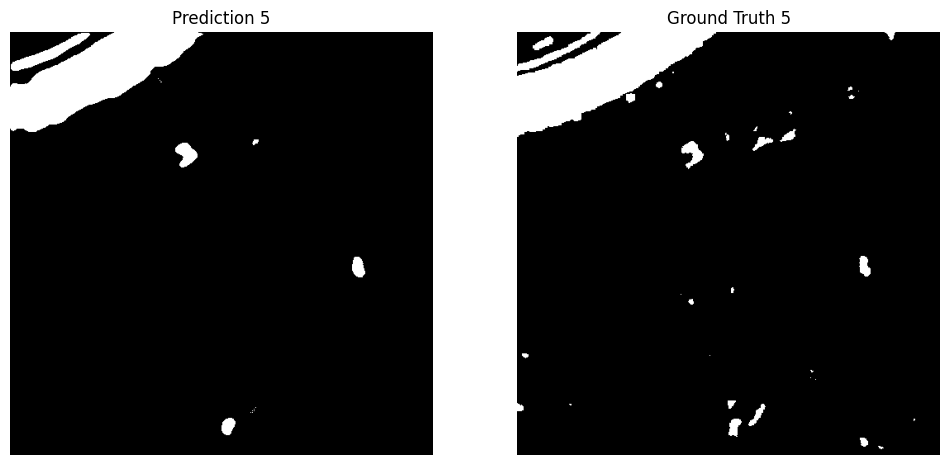

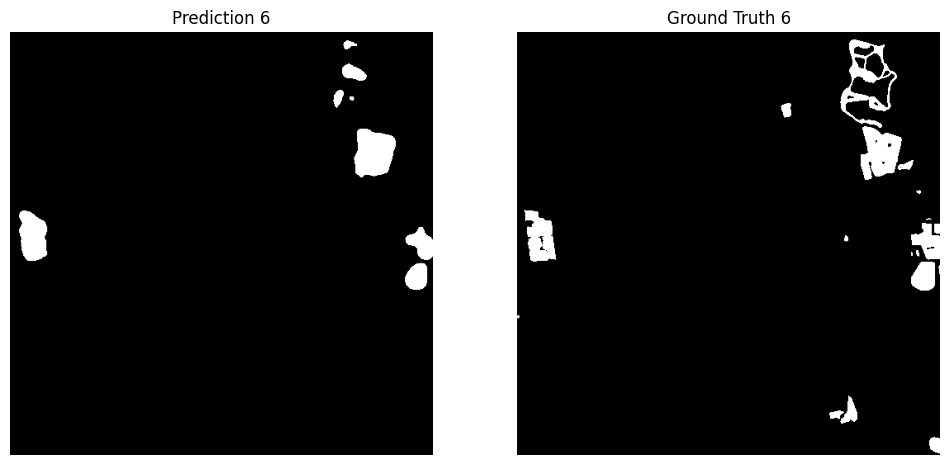

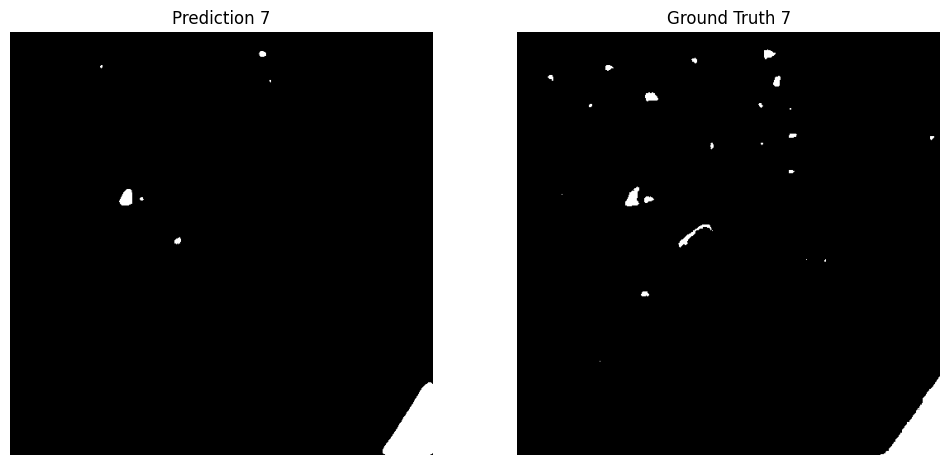

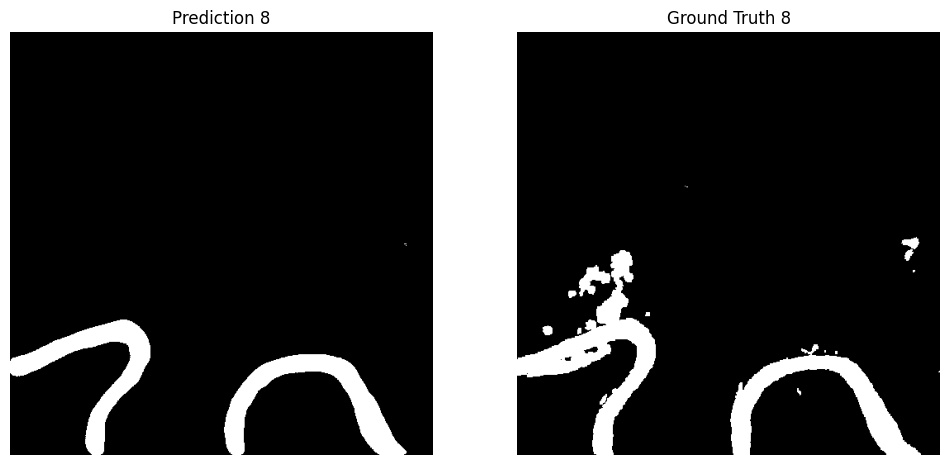

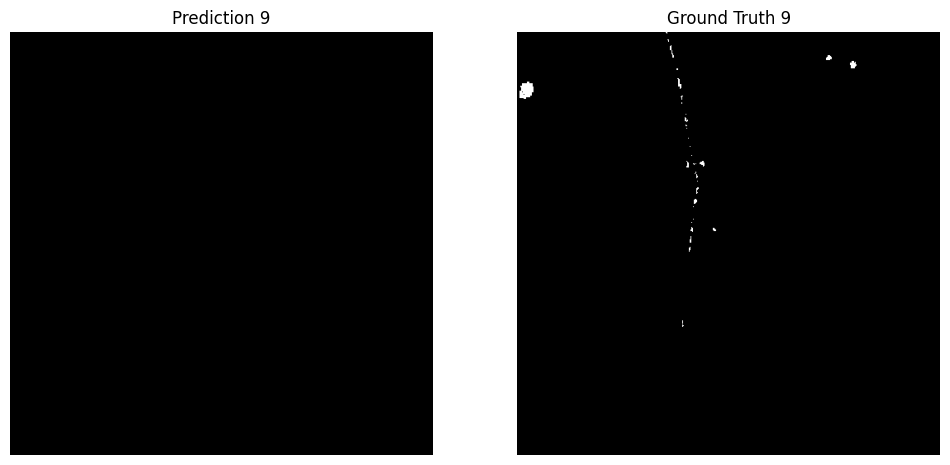

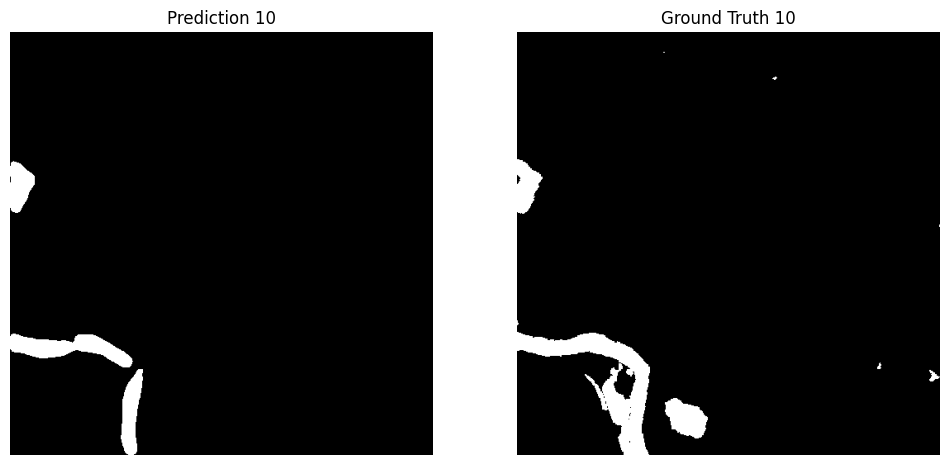

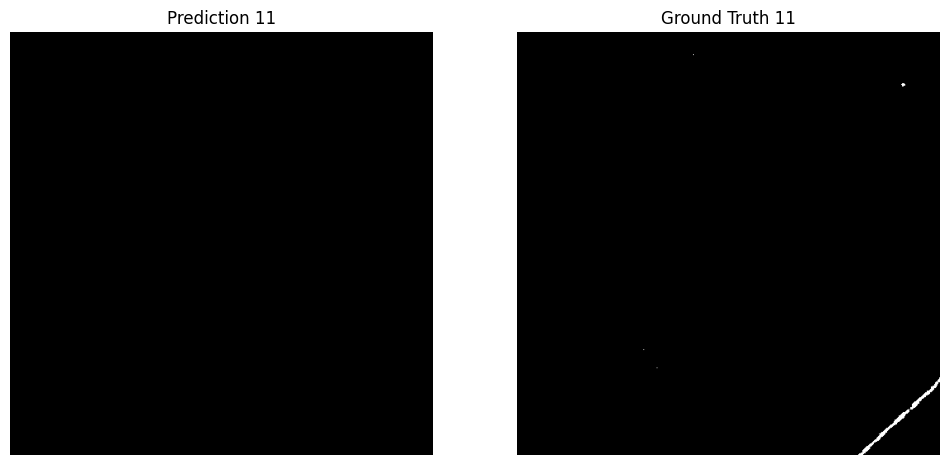

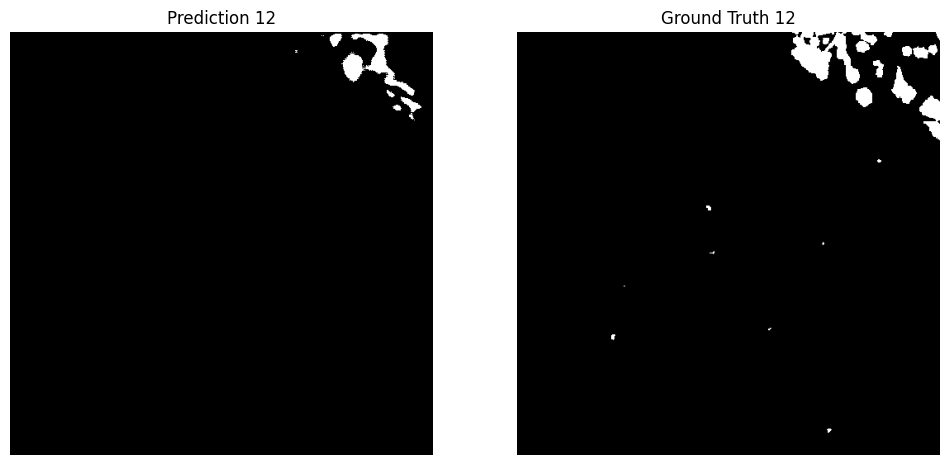

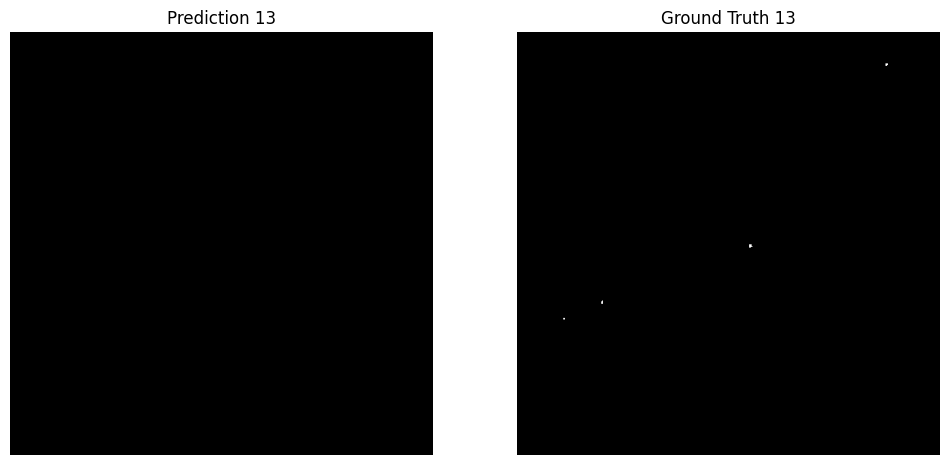

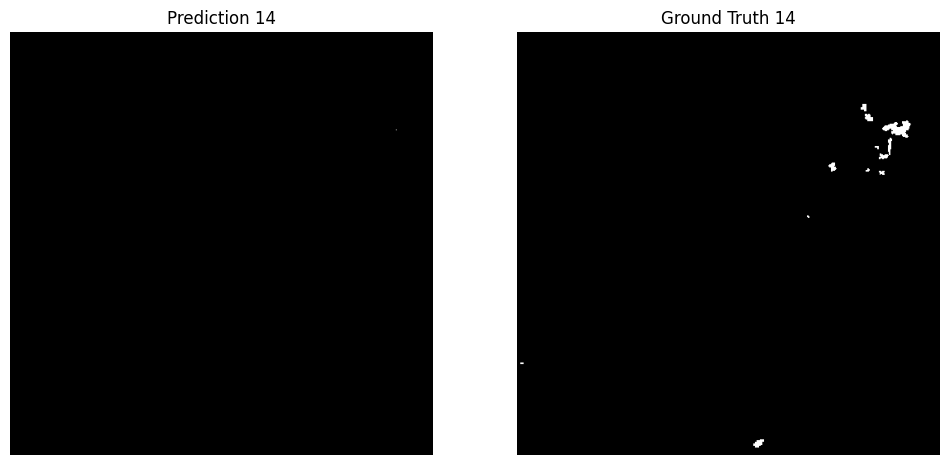

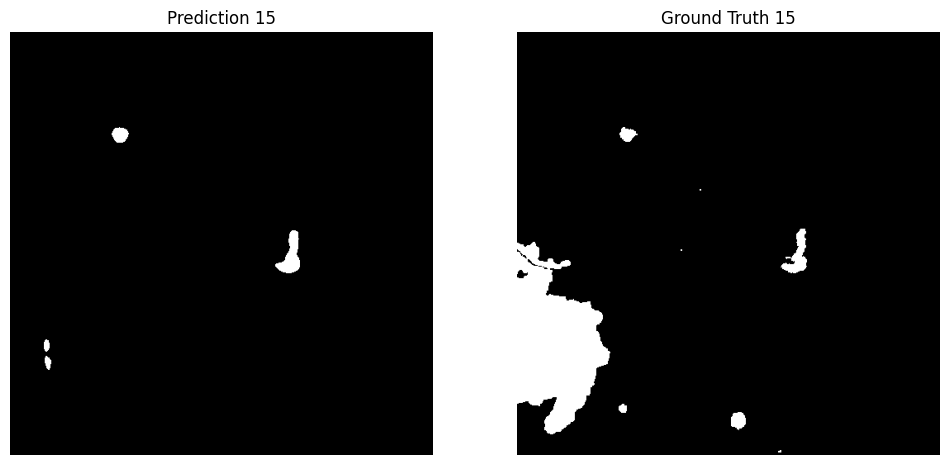

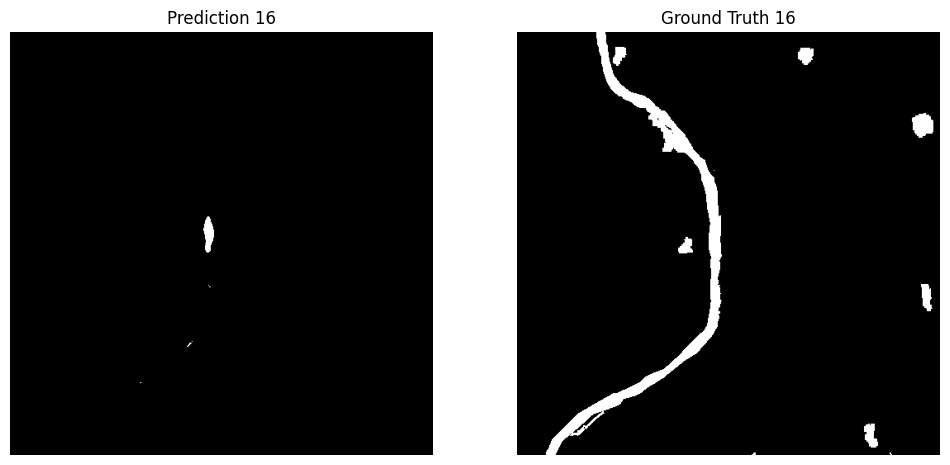

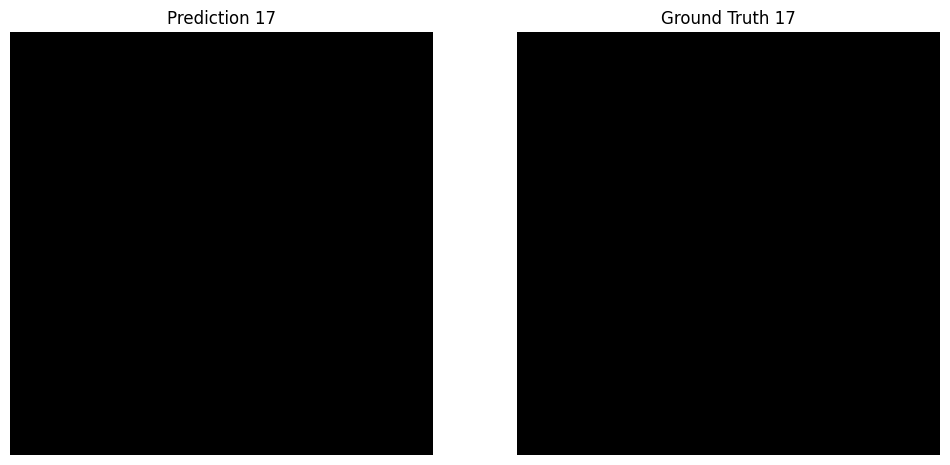

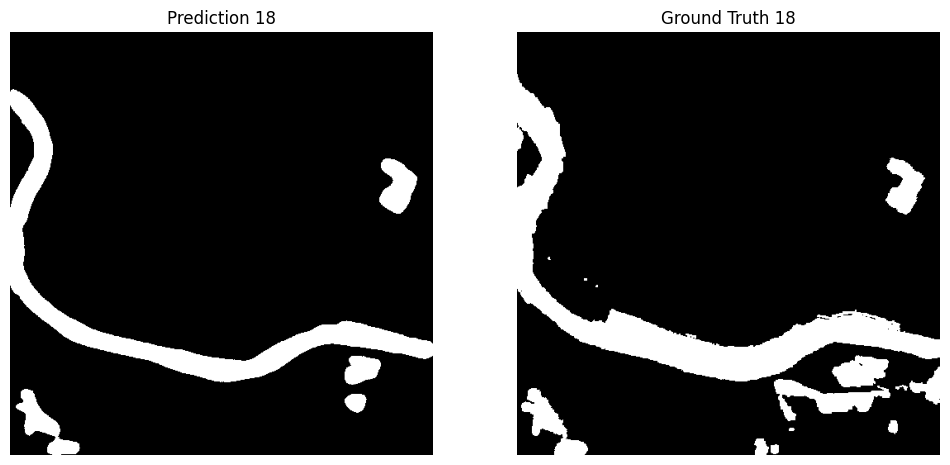

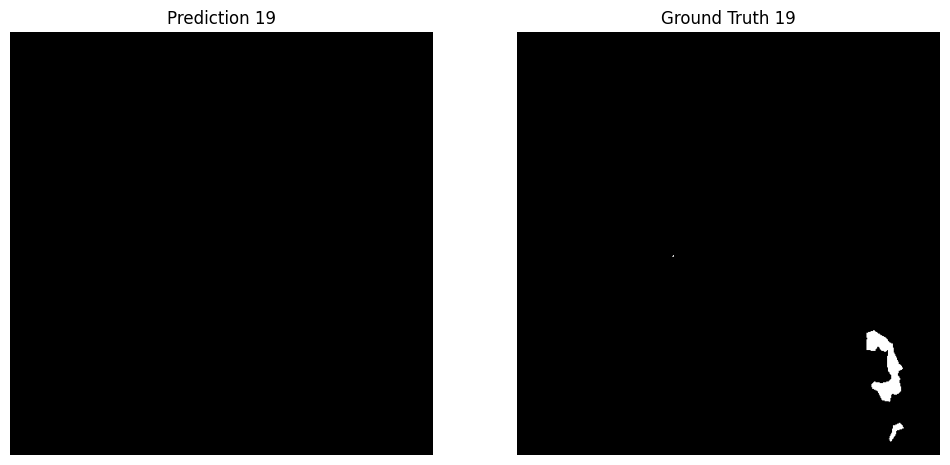

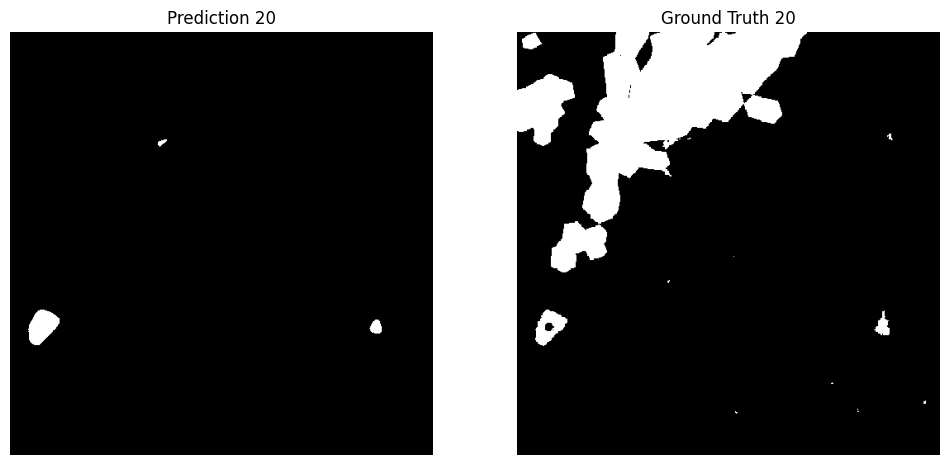

epoch 3


100%|██████████| 82/82 [03:29<00:00,  2.55s/it, loss=0.256]


=> Saving checkpoint
Checking accuracy...
Preds white: 256656.0
Preds black: 3937648
Preds white: 111442.0
Preds black: 4082862
Preds white: 123669.0
Preds black: 4070635
Preds white: 345305.0
Preds black: 3848999
Preds white: 65773.0
Preds black: 4128531
Preds white: 55185.0
Preds black: 4139119
Preds white: 34365.0
Preds black: 4159939
Preds white: 298990.0
Preds black: 3895314
Preds white: 210307.0
Preds black: 3983997
Preds white: 414168.0
Preds black: 3780136
Preds white: 32275.0
Preds black: 4162029
Preds white: 294804.0
Preds black: 3899500
Preds white: 255725.0
Preds black: 3938579
Preds white: 248312.0
Preds black: 3945992
Preds white: 246503.0
Preds black: 3947801
Preds white: 28073.0
Preds black: 4166231
Preds white: 147347.0
Preds black: 4046957
Preds white: 106824.0
Preds black: 4087480
Preds white: 78888.0
Preds black: 4115416
Preds white: 144700.0
Preds black: 4049604
Preds white: 47810.0
Preds black: 1525054
Got 82983648/85458944 with acc 97.10
Dice score: 0.67657369375

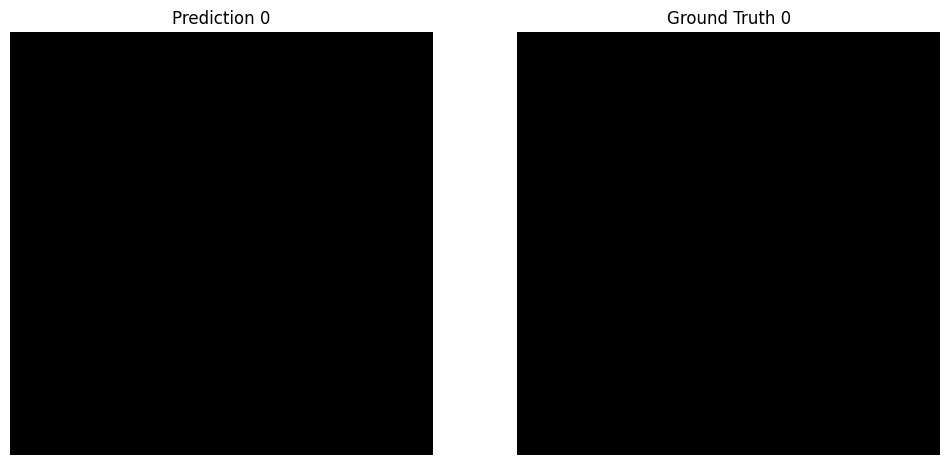

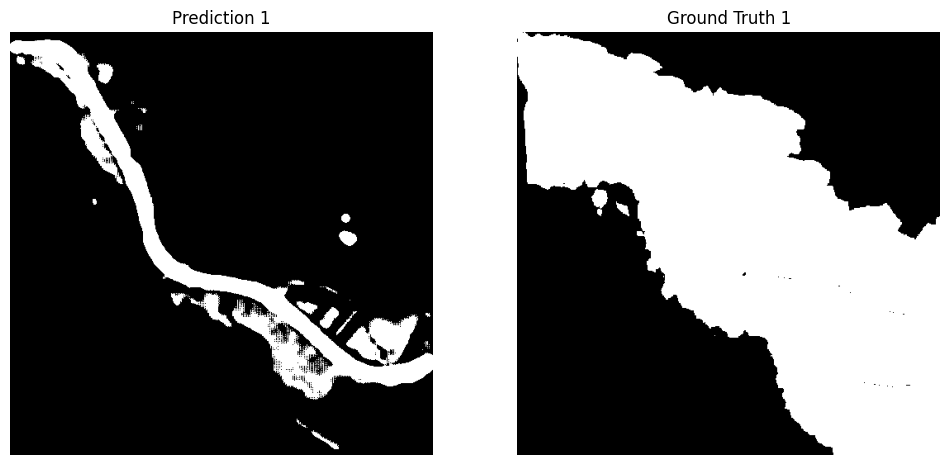

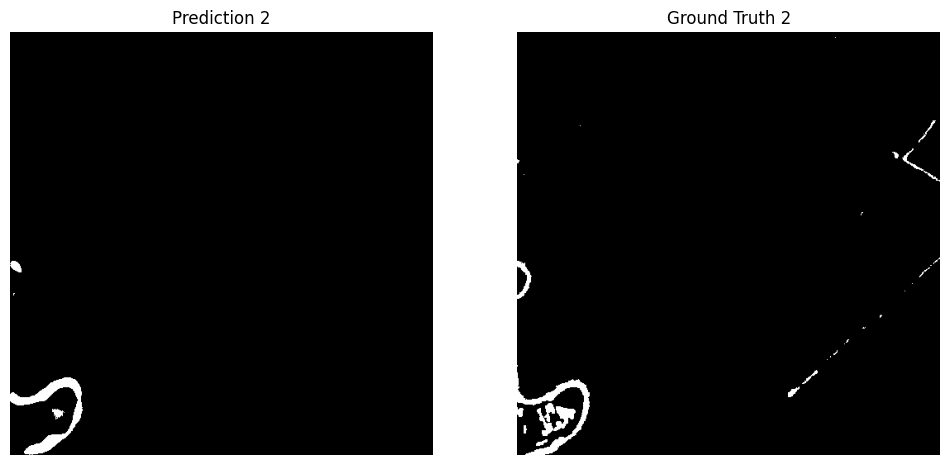

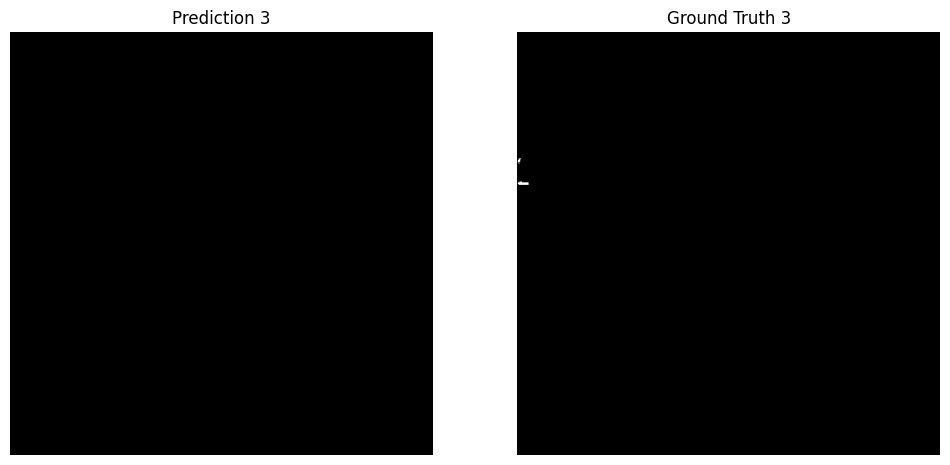

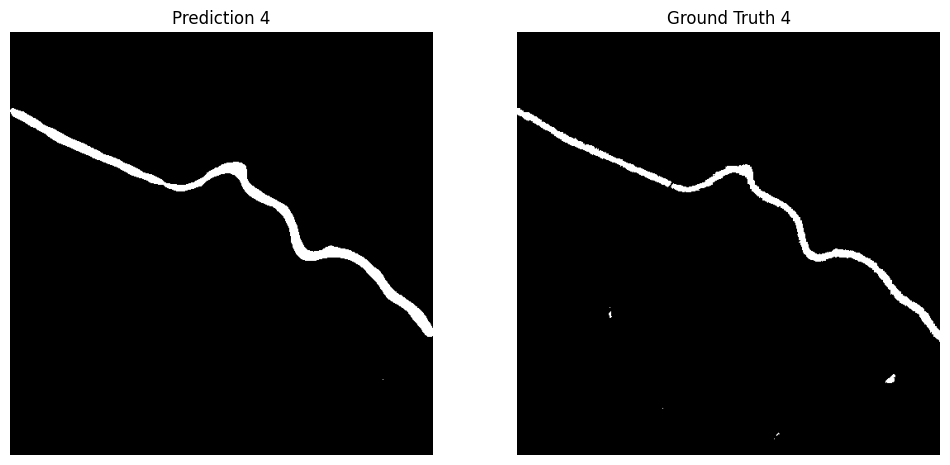

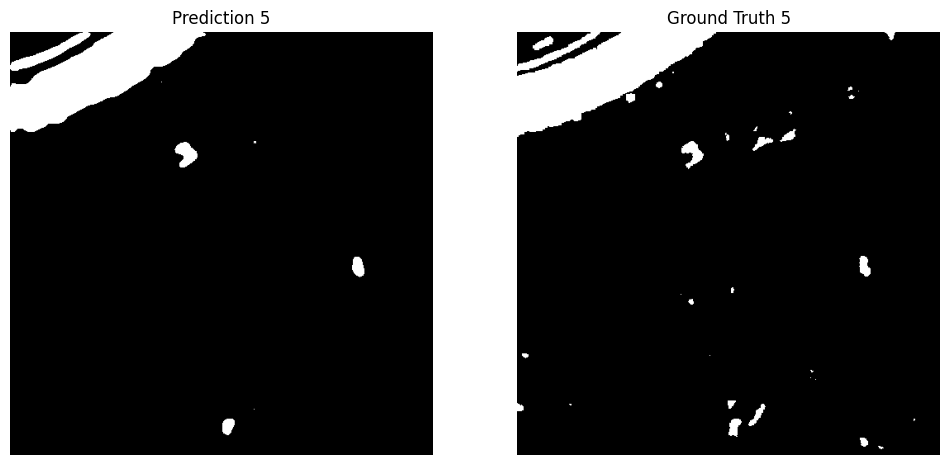

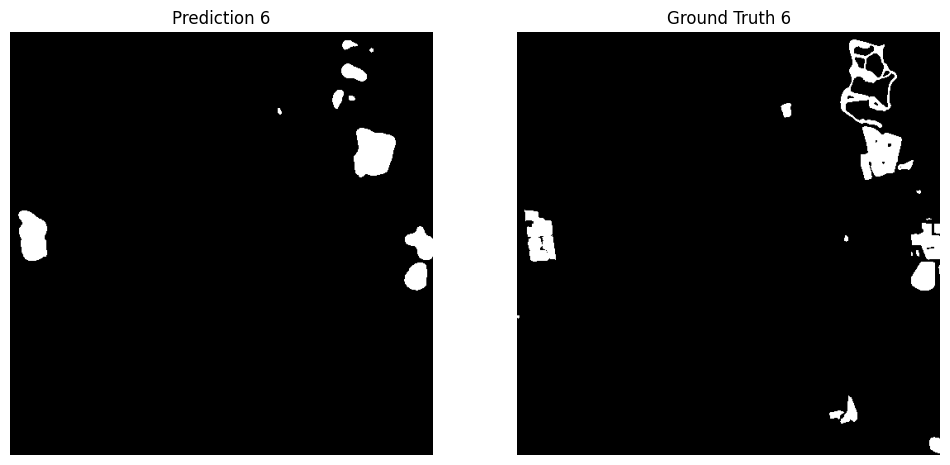

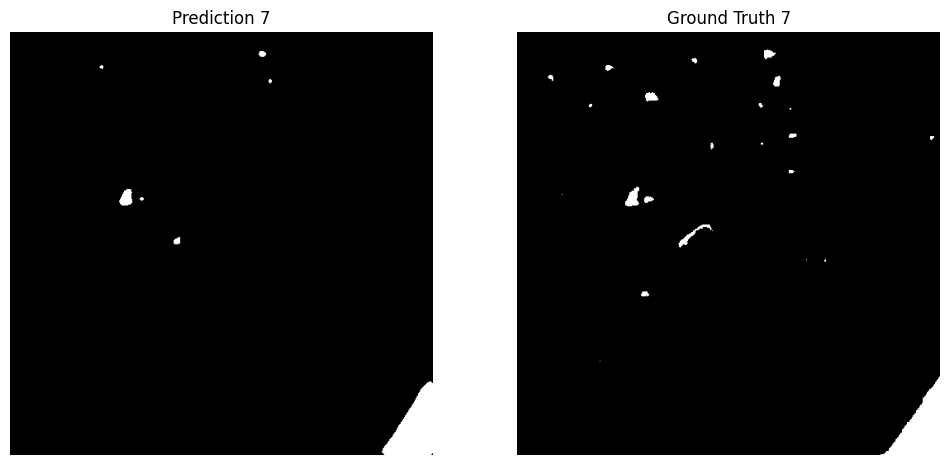

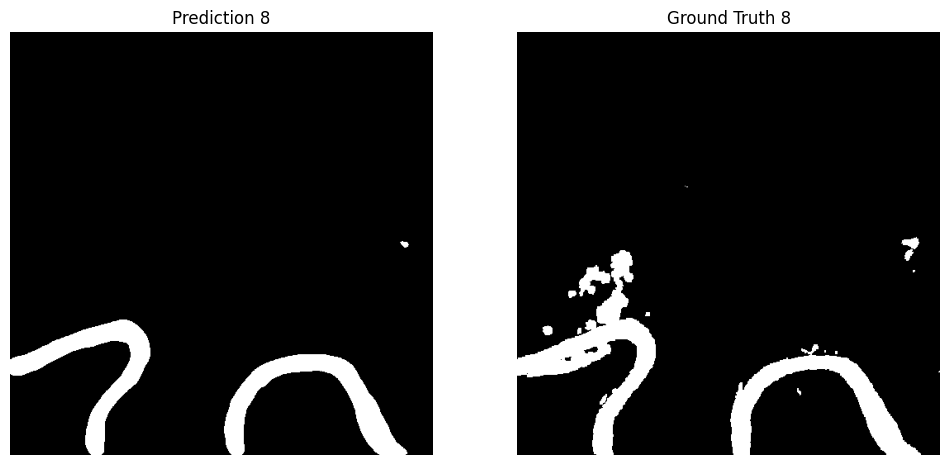

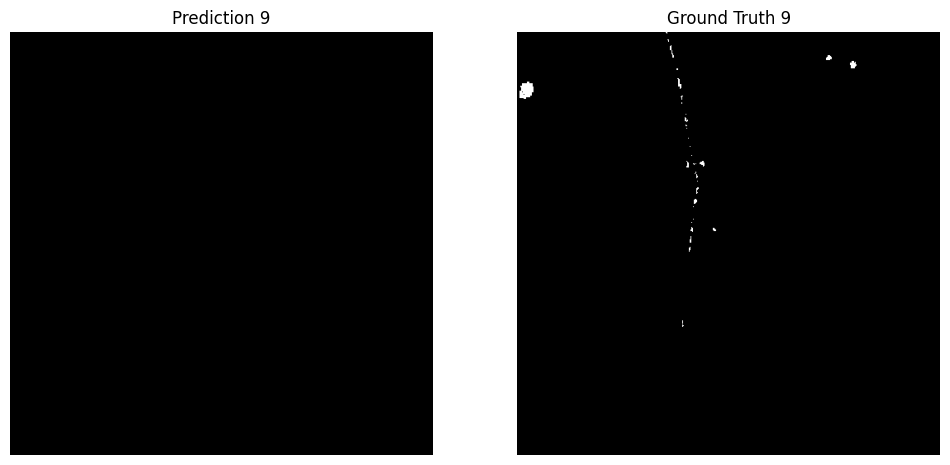

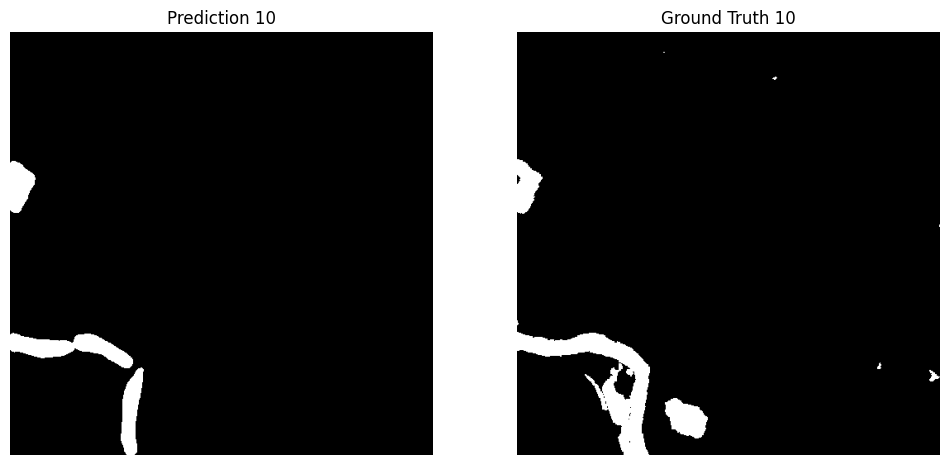

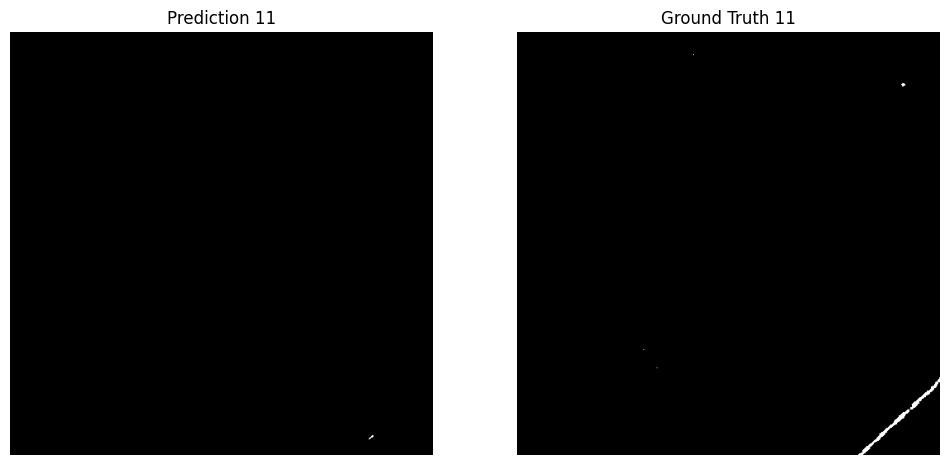

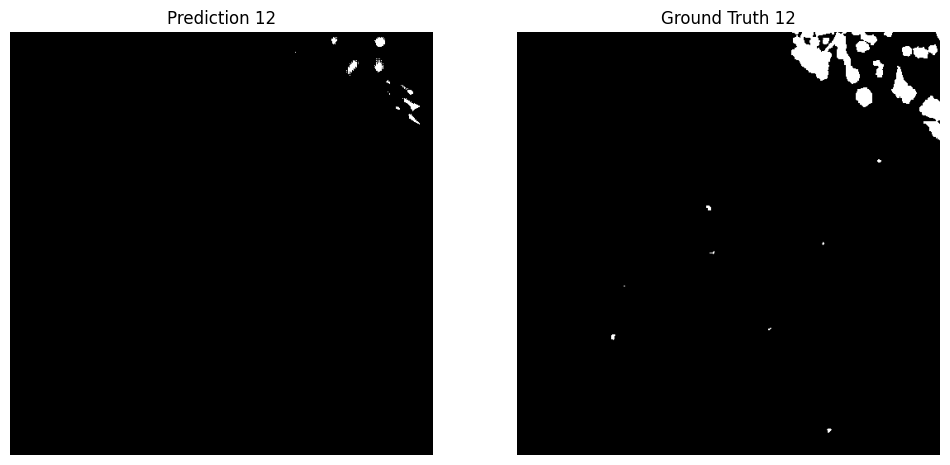

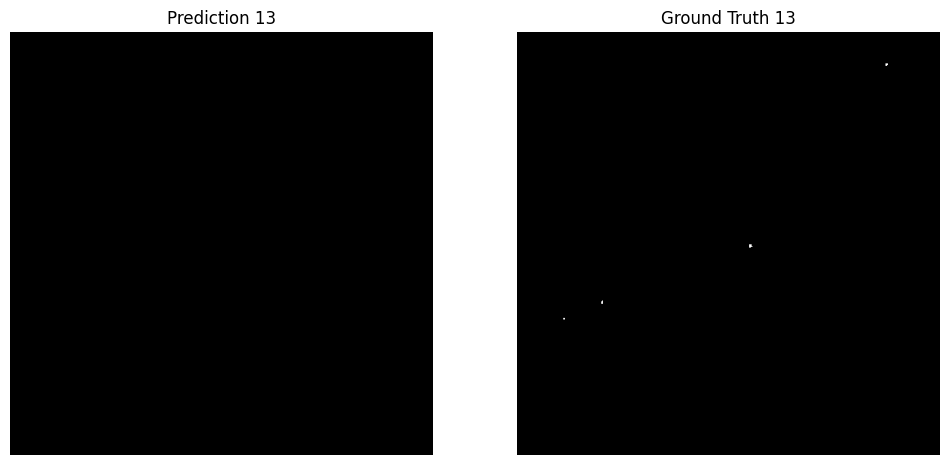

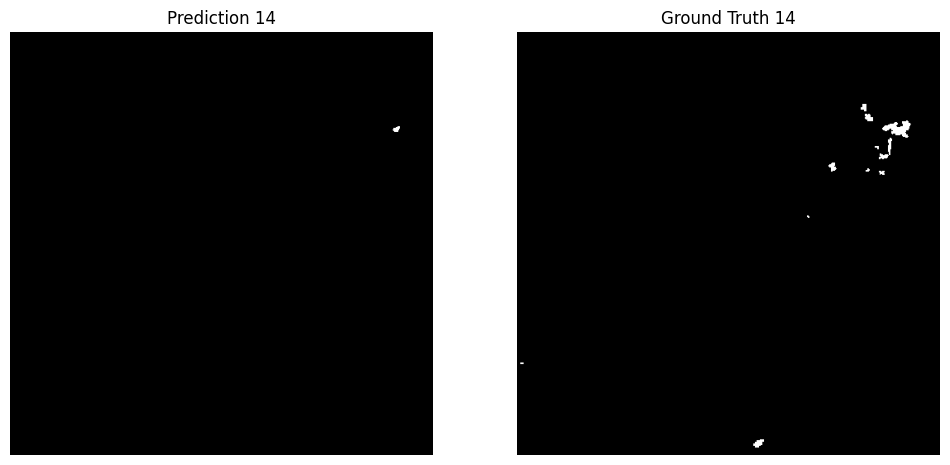

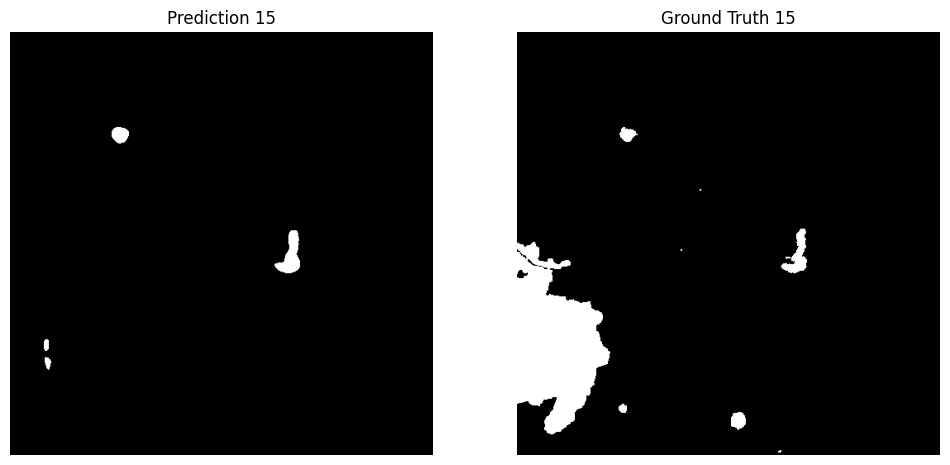

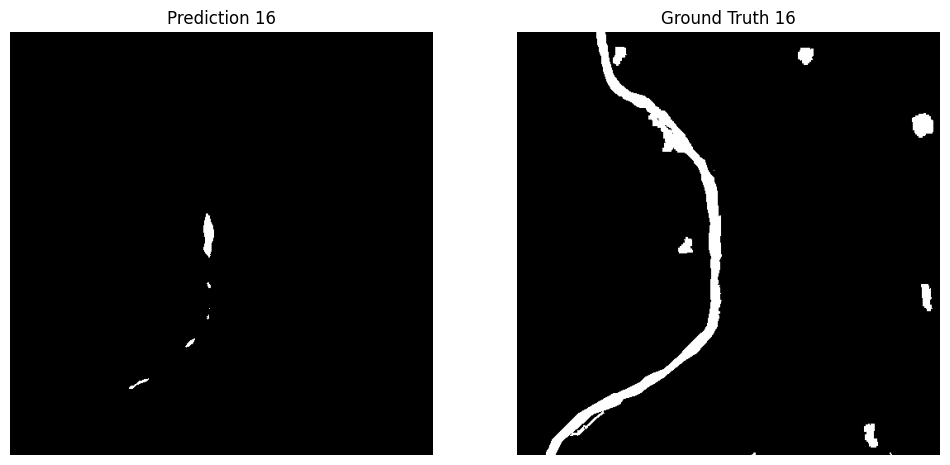

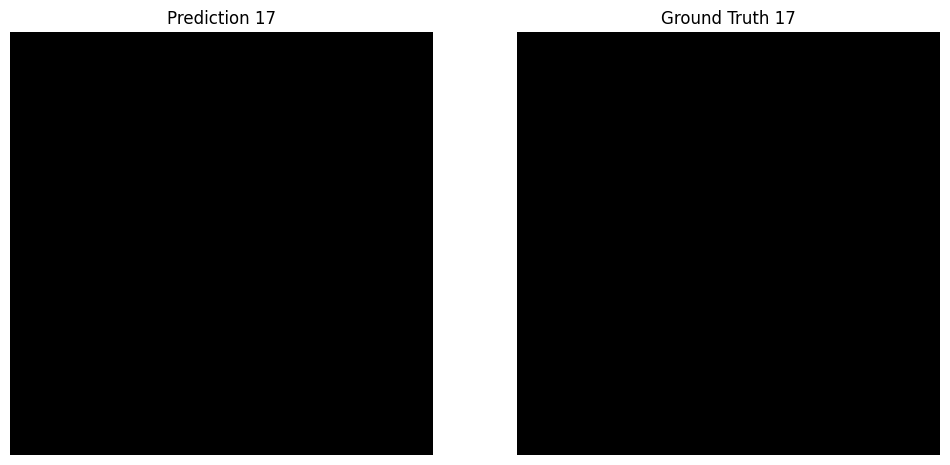

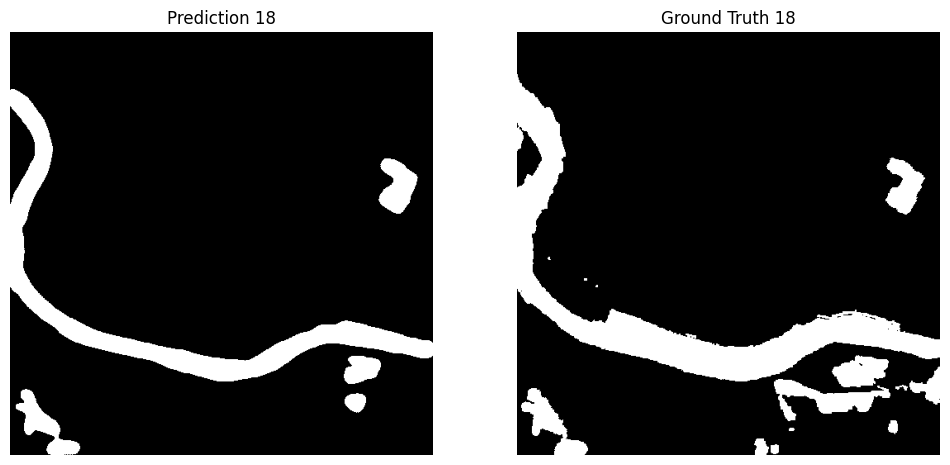

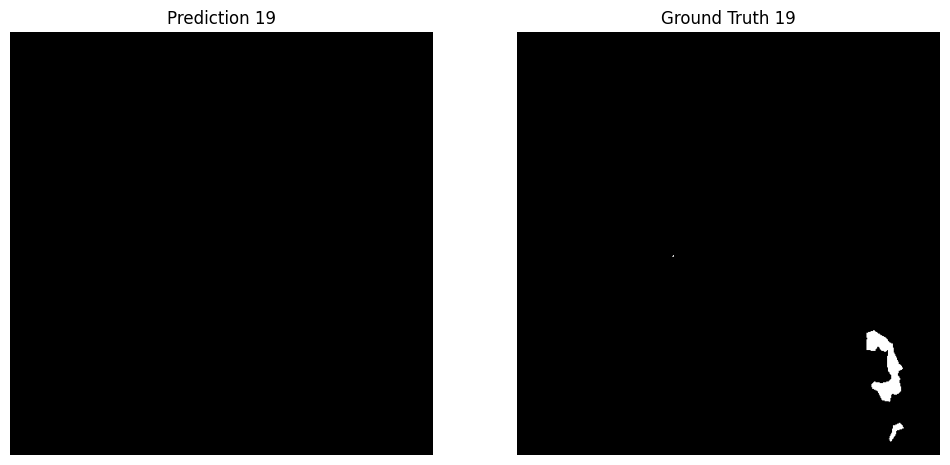

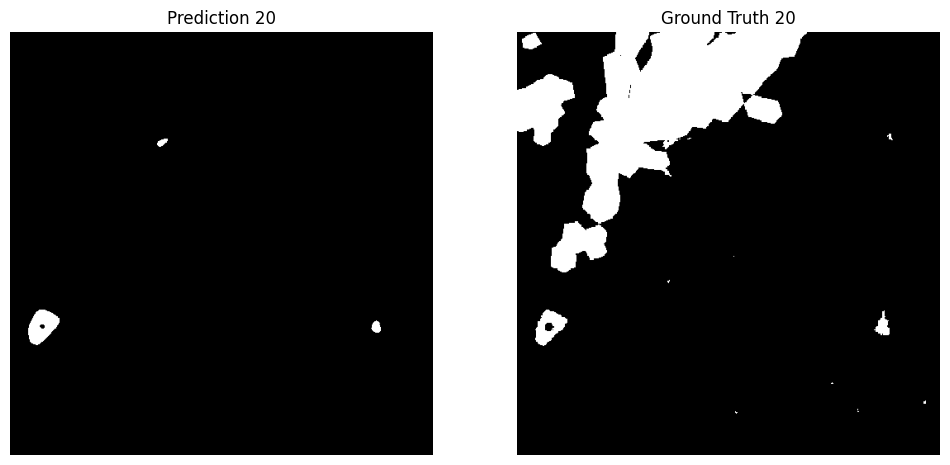

epoch 4


100%|██████████| 82/82 [03:28<00:00,  2.54s/it, loss=0.166]


=> Saving checkpoint
Checking accuracy...
Preds white: 227244.0
Preds black: 3967060
Preds white: 94236.0
Preds black: 4100068
Preds white: 111639.0
Preds black: 4082665
Preds white: 323628.0
Preds black: 3870676
Preds white: 52408.0
Preds black: 4141896
Preds white: 50548.0
Preds black: 4143756
Preds white: 31536.0
Preds black: 4162768
Preds white: 293554.0
Preds black: 3900750
Preds white: 183184.0
Preds black: 4011120
Preds white: 400970.0
Preds black: 3793334
Preds white: 29351.0
Preds black: 4164953
Preds white: 292091.0
Preds black: 3902213
Preds white: 231377.0
Preds black: 3962927
Preds white: 242777.0
Preds black: 3951527
Preds white: 242424.0
Preds black: 3951880
Preds white: 23721.0
Preds black: 4170583
Preds white: 142278.0
Preds black: 4052026
Preds white: 100546.0
Preds black: 4093758
Preds white: 70676.0
Preds black: 4123628
Preds white: 131101.0
Preds black: 4063203
Preds white: 46811.0
Preds black: 1526053
Got 82836385/85458944 with acc 96.93
Dice score: 0.652154564857

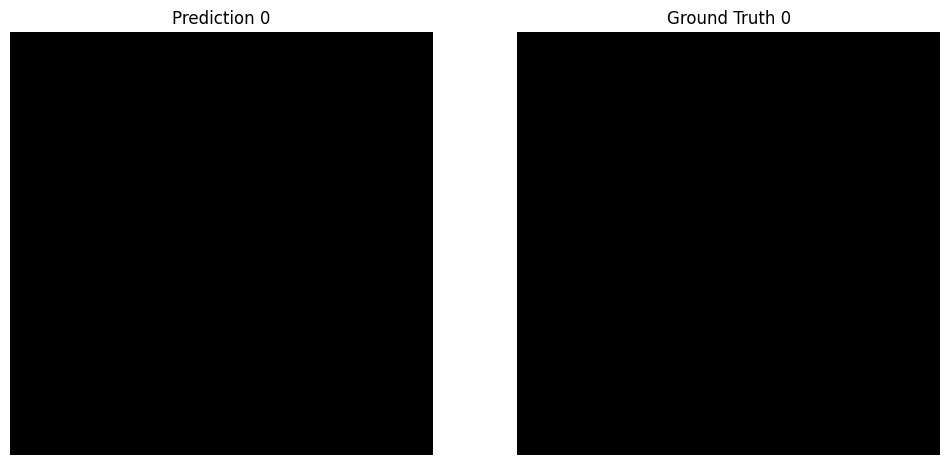

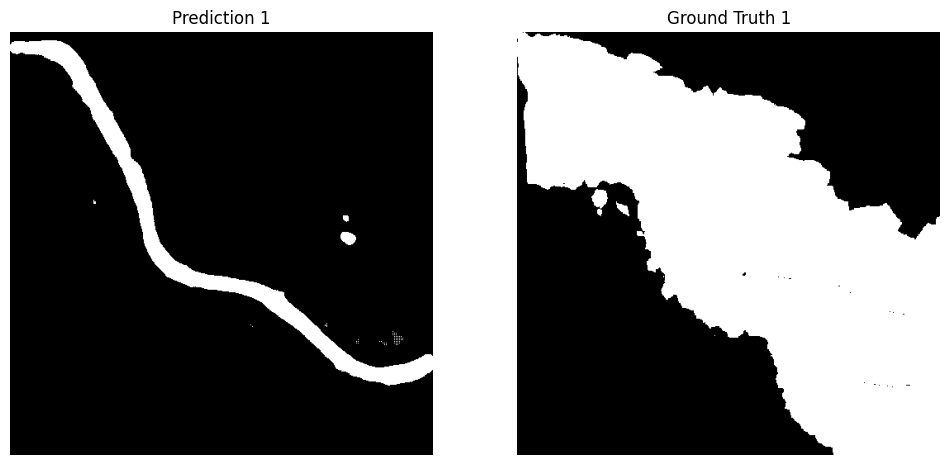

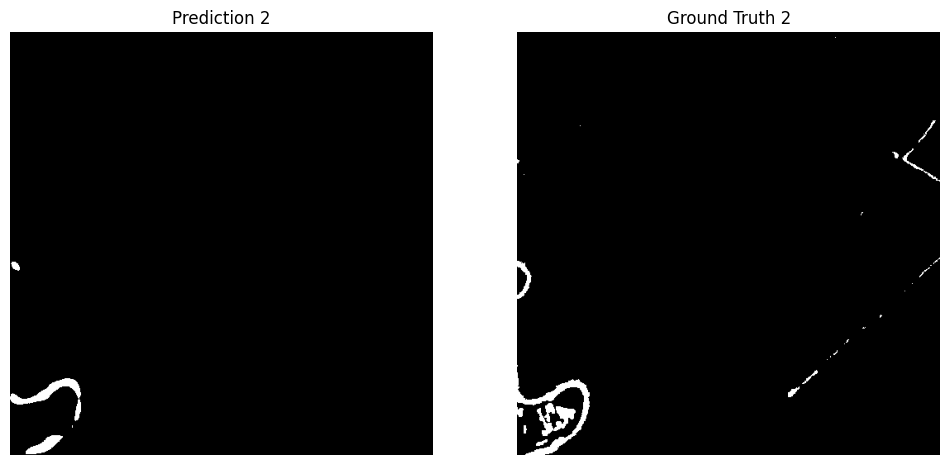

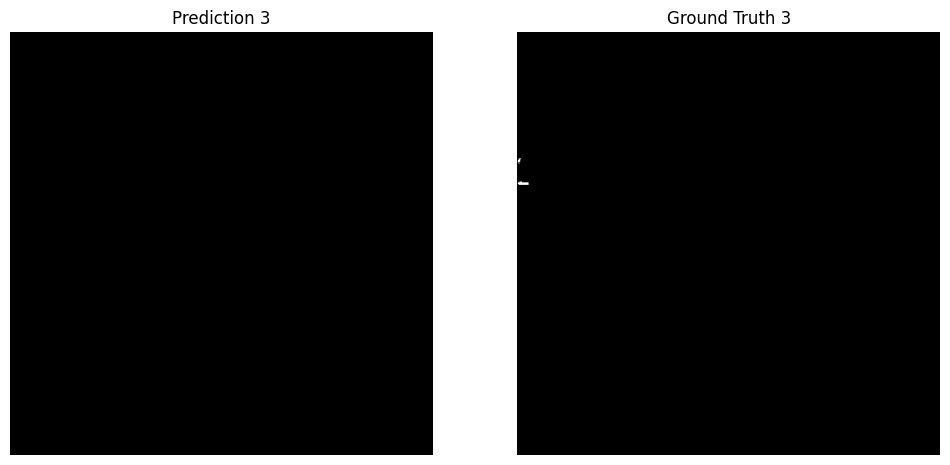

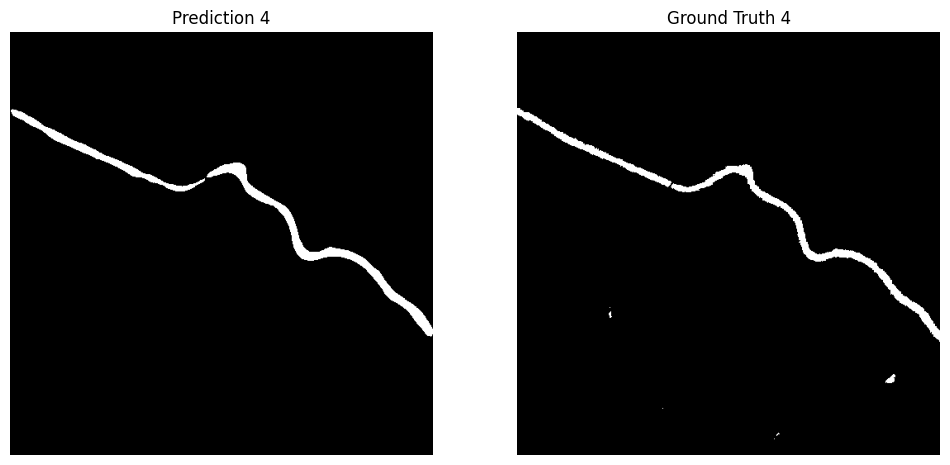

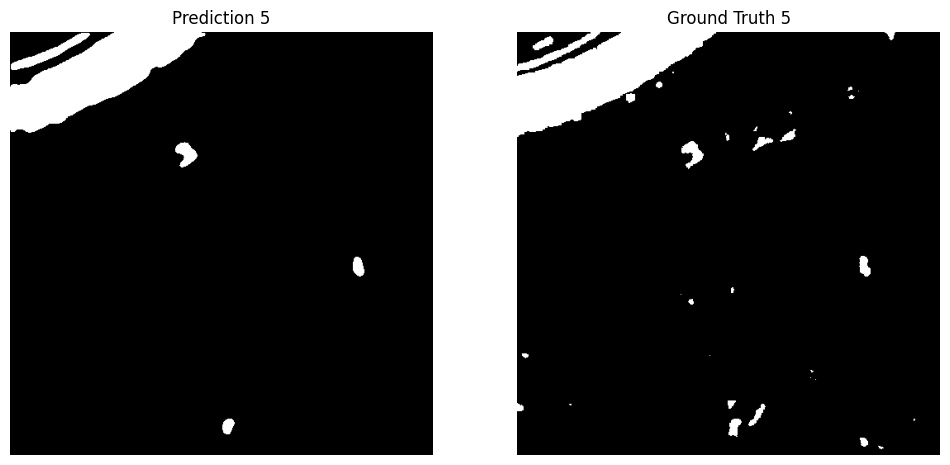

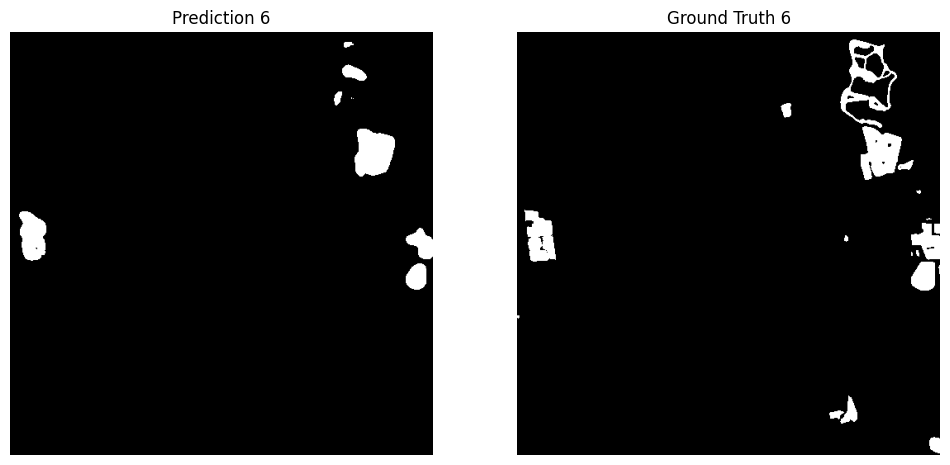

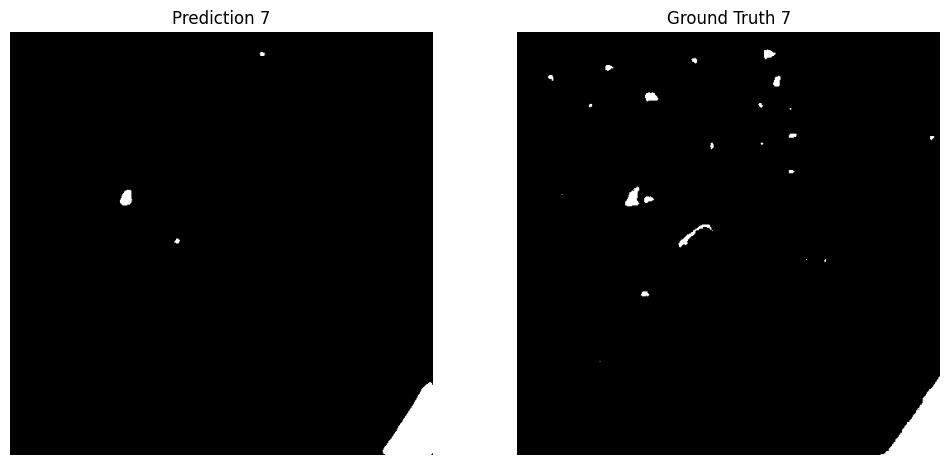

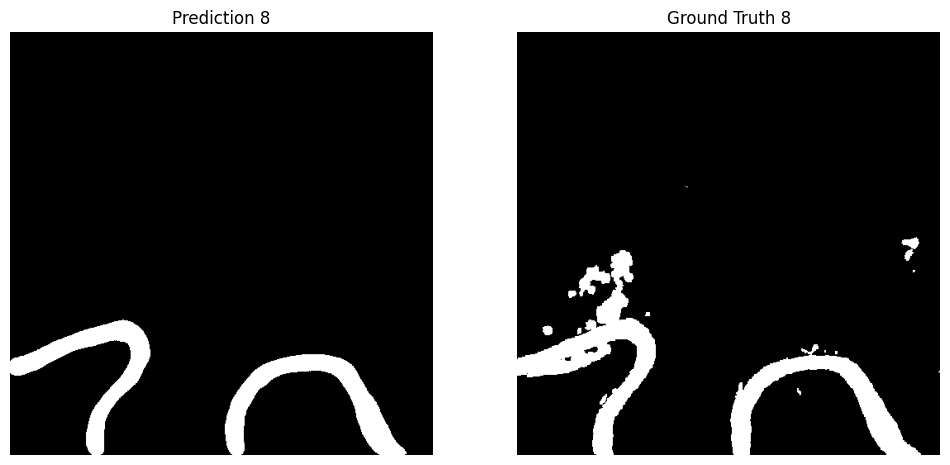

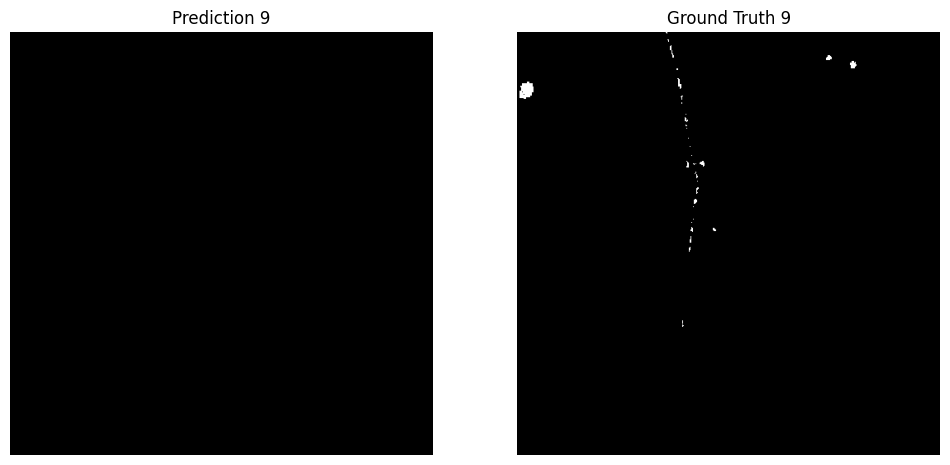

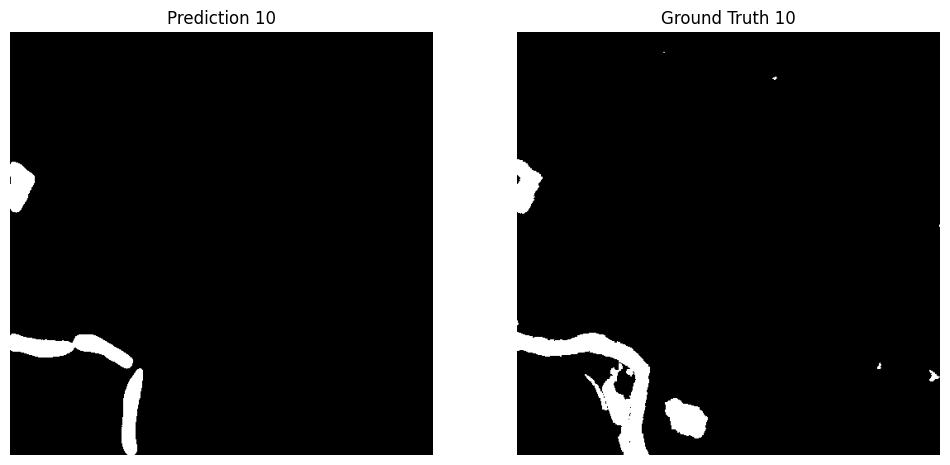

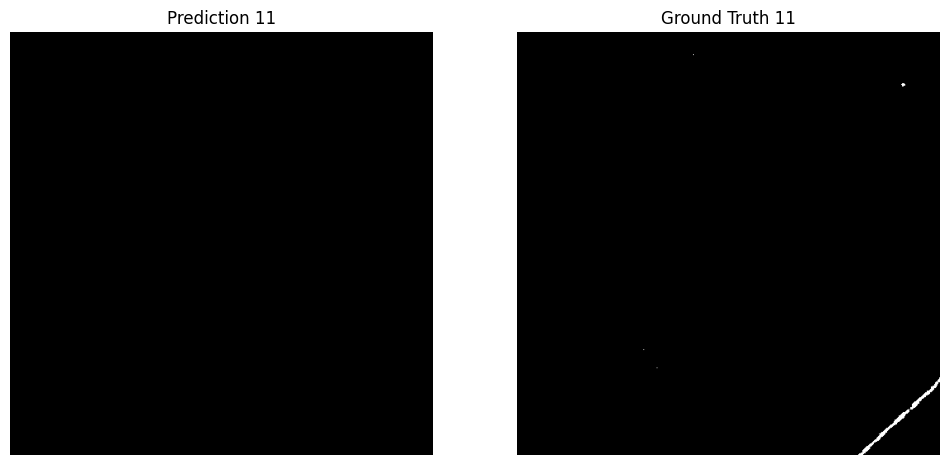

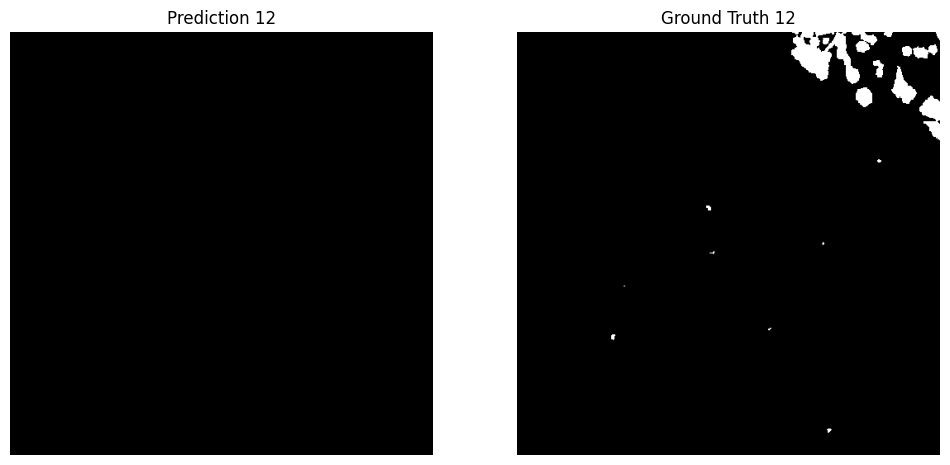

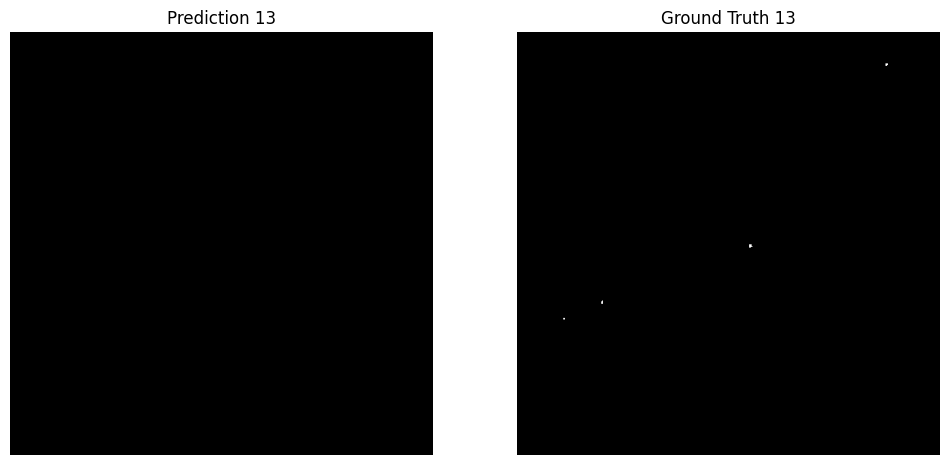

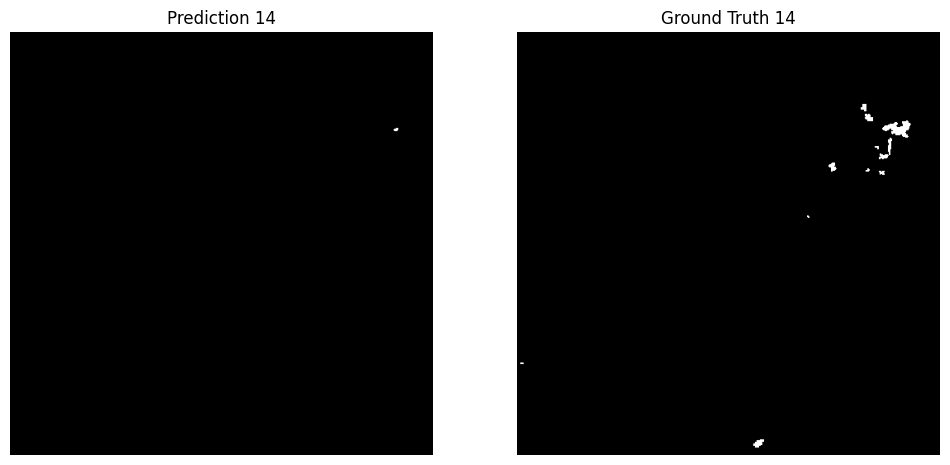

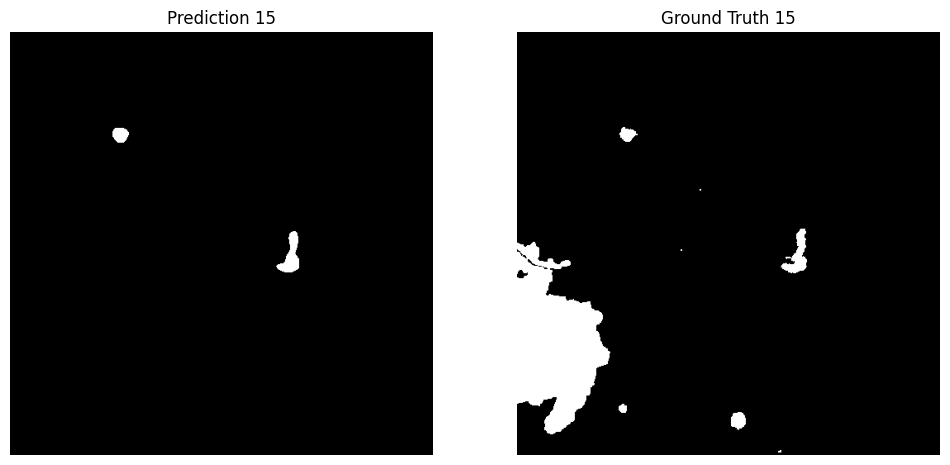

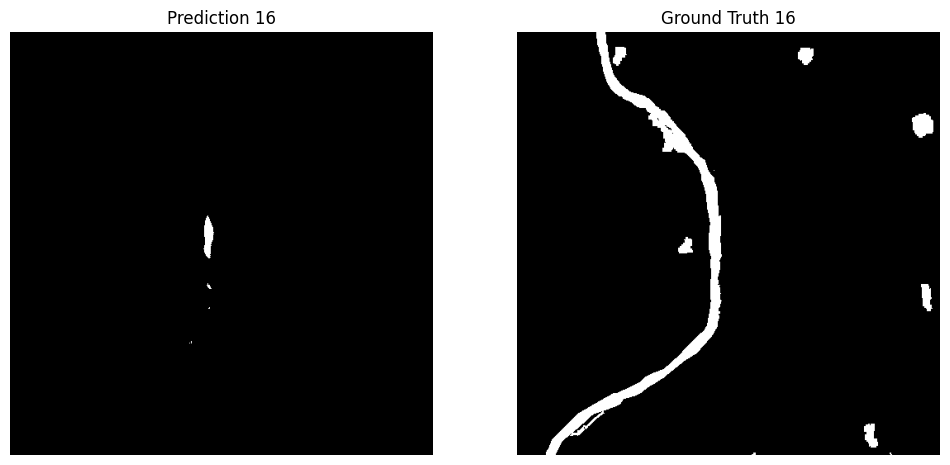

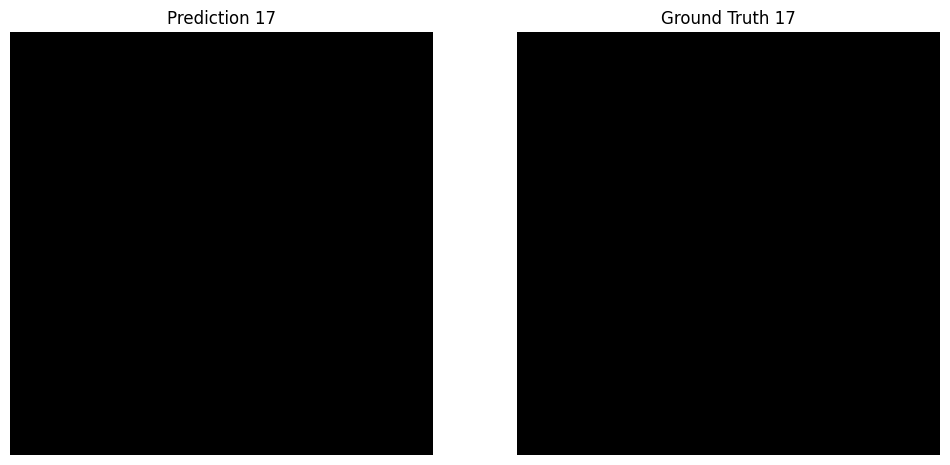

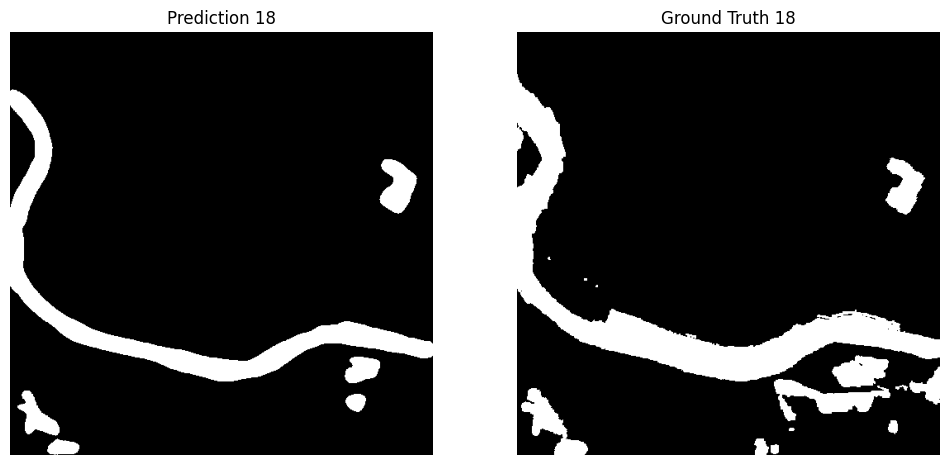

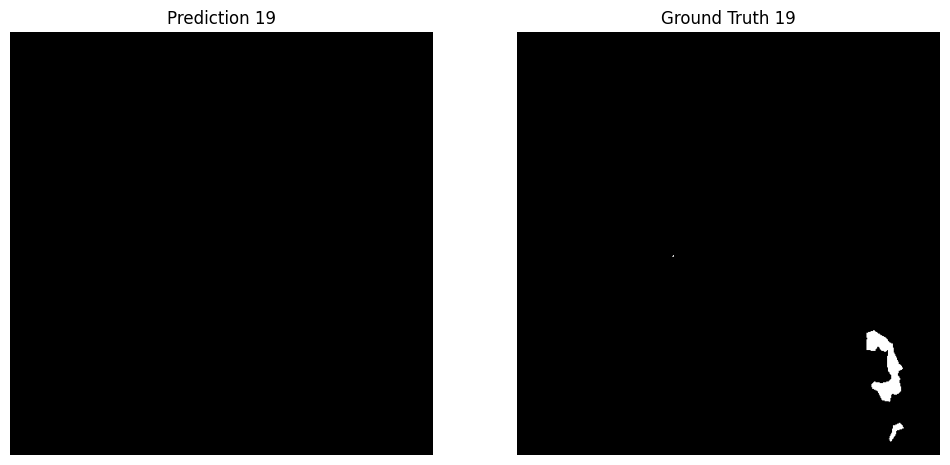

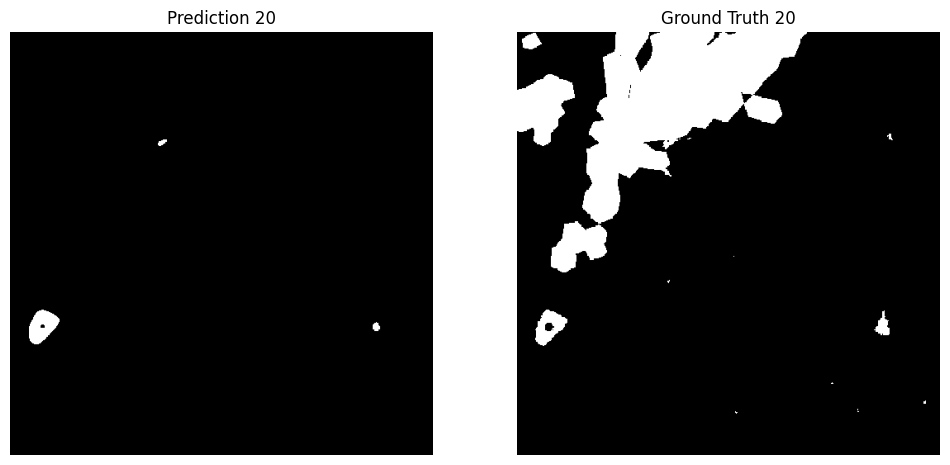

In [7]:
import torch
import gc

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm # progress bar
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt



# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 4
NUM_WORKERS = 2 # number of CPU cores to use for data loading
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
PIN_MEMORY = True  # it means that the data loader copies Tensors into CUDA pinned memory before returning them, which can speed up memory transfers from CPU to GPU
LOAD_MODEL = False # it means we are loading a model, not training a new model

# create subfolders under data with these names!!!
TRAIN_IMG_DIR = "/content/drive/MyDrive/Track1/train/images"
TRAIN_MASK_DIR = "/content/drive/MyDrive/Track1/train/labels"
VAL_IMG_DIR = "/content/drive/MyDrive/Track1/val/images"
VAL_MASK_DIR = "/content/drive/MyDrive/Track1/val/labels"

def train_fn(loader, model, optimizer, loss_fn, scaler): #one epoch
    loop = tqdm(loader) # progress bar

    for batch_idx, (data, targets) in enumerate(loop):

        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE) # adds a channel dimension with unsqueeze

        # forward, float16 training for faster computation
        with torch.cuda.amp.autocast(): # automatic mixed precision
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

def main():

    # data augmentation to prevent overfitting
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0]*6,
                std=[1.0]*6,
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    print("Data augmentation is set.")
    # validation data augmentation, only resize and normalize since augmentating validation data goes against the purpose of validation
    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0]*6,
                std=[1.0]*6,
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    print("Validation data augmentation is set.")
    model = UNet(in_channels=6, out_channels=1).to(DEVICE)
    print("Model is set.")
    loss_fn = nn.BCEWithLogitsLoss() # binary cross entropy with logits loss because we are using sigmoid activation function in the final layer and doing a binary classification
    print("Loss function is set.")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    print("Optimizer is set.")

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )
    print("Data loaders are set.")

    if LOAD_MODEL:
        load_checkpoint(torch.load("/content/drive/MyDrive/my_checkpoint.pth.tar"), model, optimizer)
        print("Model is loaded.")


    check_accuracy(val_loader, model, device=DEVICE)
    print("Accuracy is checked.")
    # we don't have cuda so we can't use mixed precision
    scaler = torch.cuda.amp.GradScaler() # automatic mixed precision

    for epoch in range(NUM_EPOCHS):
        print(f"epoch {epoch+1}")
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(), # model weights
            "optimizer":optimizer.state_dict(), # optimizer state, e.g. learning rate, momentum, etc.
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="/content/drive/MyDrive/Track1/saved_images", device=DEVICE
        )


if __name__ == "__main__": # to not have issues when running NUM_WORKERS on Windows
    gc.collect()
    main()
    gc.collect()



def save_predictions_as_imgs(loader, model, folder="/content/drive/MyDrive/Track1test/saved_images", device="cuda"):
    model.eval()

    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            preds = (preds * 255).type(torch.uint8).clamp(0, 255)
            print(f"Preds dtype: {preds.dtype}, shape: {preds.shape}")

        # Process and save ground truth masks
        y_scaled = (y.unsqueeze(1) * 255).type(torch.uint8).clamp(0, 255)
        print(f"Y_scaled dtype: {y_scaled.dtype}, shape: {y_scaled.shape}")


        for img_idx, (pred, gt) in enumerate(zip(preds, y_scaled)):
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            
            # Display the prediction
            ax[0].imshow(pred.squeeze().cpu().numpy(), cmap='gray')
            ax[0].set_title(f'Prediction {img_idx}')
            ax[0].axis('off')

            # Display the ground truth
            ax[1].imshow(gt.squeeze().cpu().numpy(), cmap='gray')
            ax[1].set_title(f'Ground Truth {img_idx}')
            ax[1].axis('off')

            plt.show()

        # Save predictions
        try:
          torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.jpeg")
        except RuntimeError as e:
            print(f"Failed to save image: {e}")
            print(f"Tensor stats -> Min: {preds.min()}, Max: {preds.max()}, Type: {preds.dtype}, Shape: {preds.shape}")

        try:
          torchvision.utils.save_image(y_scaled, f"{folder}/mask_{idx}.jpeg")
        except RuntimeError as e:
            print(f"Failed to save image: {e}")
            print(f"Tensor stats -> Min: {y_scaled.min()}, Max: {y_scaled.max()}, Type: {y_scaled.dtype}, Shape: {y_scaled.shape}")



    model.train()